# Project Goals
* Access JSON file from Amazon Server - Create a dataframe
* Data Augmentation using Aleatoric uncertainty.

* Anomaly / Outlier Detection 
* Predict Peak Heat Release Rate
    * Regression Analysis with tabular data ( ensemble methods)
    
* Predict Fuel Type
    * Classification with tabular data (ensemble methods
    
* Shapley Value


# Import Libraries

In [91]:
# Import models

import json
import urllib.request
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns

import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor

from sklearn.inspection import permutation_importance

from itertools import product
from collections import OrderedDict


from scipy import stats

#!pip install pyod
#!pip install --upgrade pyod

# Linear Model
from pyod.models.pca import PCA

# Proximity Based
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN

# Probabilistic
from pyod.models.abod import ABOD

# Outlier Ensembles
from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.xgbod import XGBOD

# Neural Networks
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE

from prettytable import PrettyTable


# Read json file from AWS Server

In [92]:
json_url = "https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1528807400.json"

with urllib.request.urlopen(json_url) as url:
    json_data = json.loads(url.read().decode())

# key value pairs in json file. store in dataframe

In [93]:
print(json.dumps(json_data, indent=4))

{
    "id": "1528807400",
    "publish": 1,
    "created": 1528807400,
    "updated": 1621023884,
    "name": "B6-1",
    "date": "6/12/2018 8:43:06 AM",
    "description": "Fire Barrier: B6, Cover Fabric: Polypropylene (3kg), Filling Material: Polyethalene (6kg) and Polyester (4 kg)",
    "specimen": "upholstered chair mockup",
    "ignition": "18 kW propane square burner",
    "project_ids": [
        {
            "name": "BarrierFabricMockup"
        },
        {
            "name": "null"
        }
    ],
    "test_director": "Zammarano",
    "timelapse_video_with_heat_release_rate_plot": "https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/ASSET_FILES/Chair_Mockup/video/1528807400.mp4",
    "csv_data_file": "https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/ASSET_FILES/Chair_Mockup/data/1528807400_B6-1.csv",
    "peak_heat_release_rate": {
        "value": 1080.02,
        "combined_expanded_uncertainty": 65.06385841722715,
        "unit": "kW",
        "label": "Peak Heat Release Rate, PHRR

In [94]:
json_url_filename = "S3_AWS_JSON_LIST.csv" # Small Dataset 197 experiments
json_url_filename = "HTTP_NFRL1_JSON_FileList.csv" # Large Dataset with over 1000 experiments
json_urls = pd.read_csv(json_url_filename)["url_name"].values

In [95]:
cols = [
        "id",
        "Peak_Heat_Release_Rate",
        "time_to_peak_heat_release_rate", 
        "total_heat_released",
        "total_fuel_mass_burned", 
        "o2_yield", 
        "co2_yield",
        "co_yield", 
        "soot_yield", 
        "test_duration", 
        "fuel_type", 
        "net_fuel_mass",
       ]
FCDSummaryValues = pd.DataFrame(columns=cols)

# Storing json values in dataframe

In [96]:
num_of_datasets = 0
read_short_dataset = False # set True for testing purposes only

for json_url in json_urls:
    num_of_datasets += 1
    if (read_short_dataset & (num_of_datasets >100)):
        break
    if ((num_of_datasets%(len(json_urls)//5))==0):
        print(f'Reading json file # {num_of_datasets} : {json_url} ...')

    with urllib.request.urlopen(json_url) as url:
        json_data = json.loads(url.read().decode())
        new_df = pd.DataFrame([[
                                json_data["id"],
                                json_data["peak_heat_release_rate"]["value"], 
                                json_data["time_to_peak_heat_release_rate"]["value"],
                                json_data["total_heat_released"]["value"], 
                                json_data["total_fuel_mass_burned"]["value"], 
                                json_data["o2_yield"]["value"],
                                json_data["co2_yield"]["value"], 
                                json_data["co_yield"]["value"],
                                json_data["soot_yield"]["value"], 
                                json_data["test_duration"]["value"],
                                json_data["fuel_type"]["value"],
                                json_data["net_fuel_mass"]["value"]
                               ]],
                                columns=cols, index={str(num_of_datasets-1)})

        FCDSummaryValues = pd.concat([FCDSummaryValues, new_df])
print(f'Total Number of Datasets : {num_of_datasets}')

Reading json file # 204 : http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERIMENTS/1631712910.json ...
Reading json file # 408 : http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERIMENTS/1583174916.json ...
Reading json file # 612 : http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERIMENTS/1616435242.json ...
Reading json file # 816 : http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERIMENTS/1536175195.json ...
Reading json file # 1020 : http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERIMENTS/1647439723.json ...
Total Number of Datasets : 1021


In [97]:
FCDSummaryValues.head()

id  Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0  1647008482                   96.46                           21.45   
1  1646936290                  127.17                           11.38   
2  1646410394                   44.72                           15.55   
3  1646317604                  279.98                            9.73   
4  1646236342                  476.98                           18.90   

   total_heat_released  total_fuel_mass_burned  o2_yield  co2_yield  co_yield  \
0            173.80297               10.284199  1.215211   1.020752  0.112912   
1            126.85369                7.506136  1.312967   1.157866  0.087455   
2             36.46506                2.157696  1.229338   1.100835  0.026711   
3            199.53617                4.988404  2.901444   2.641933  0.094687   
4            260.05008                6.501252  2.824405   2.586653  0.020452   

  soot_yield test_duration              fuel_type net_fuel_mass  
0    0.00976     55.816667       PVC, Natural Gas           NaN  
1   0.018994     39.666667       PVC, Natural Gas           NaN  
2   0.011638         26.15       PVC, Natural Gas           NaN  
3    0.03949         33.75  Plastics, Natural Gas           NaN  
4   0.052682     34.866667  Plastics, Natural Gas           NaN

In [98]:
FCDSummaryValues.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1021 entries, 0 to 1020
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1021 non-null   object 
 1   Peak_Heat_Release_Rate          1021 non-null   float64
 2   time_to_peak_heat_release_rate  1021 non-null   float64
 3   total_heat_released             1021 non-null   float64
 4   total_fuel_mass_burned          1021 non-null   float64
 5   o2_yield                        1021 non-null   float64
 6   co2_yield                       1021 non-null   float64
 7   co_yield                        1021 non-null   float64
 8   soot_yield                      824 non-null    object 
 9   test_duration                   1011 non-null   object 
 10  fuel_type                       1021 non-null   object 
 11  net_fuel_mass                   206 non-null    object 
dtypes: float64(7), object(5)
memory usage: 

# Save Dataframe

In [99]:
FCDSummaryValues.to_csv('FCDSummaryValues.csv')
df= pd.read_csv("FCDSummaryValues.csv")
#df.head()

# impute missing values 
## in "net_fuel_mass" from "total_fuel_mass_burned" column. 
## Delete "total_fuel_mass_burned" column.

In [100]:
FCDSummaryValues["net_fuel_mass"]=FCDSummaryValues["net_fuel_mass"].fillna(FCDSummaryValues["total_fuel_mass_burned"])
FCDSummaryValues.drop(labels="total_fuel_mass_burned", axis=1, inplace=True)

# Label Encoding for Fuel_Type

In [101]:
le = LabelEncoder()
FCDSummaryValues["fuel_type_encoded"]= le.fit_transform(FCDSummaryValues["fuel_type"])
print(f'Unique Fuel Type in Dataset')
FCDSummaryValues["fuel_type"].unique()

Unique Fuel Type in Dataset


array(['PVC, Natural Gas', 'Plastics, Natural Gas', 'Natural Gas',
       'Polystyrene', 'Wood (MDF)', 'Generic', 'Propane', 'Methane',
       'Polyisocyanurate Foam (foil-backed)',
       'Extruded Polystyrene Foam (XPS)',
       'Cross-linked polyethylene foam (XLPE)', 'Western Red Cedar',
       'High Impact Polystyrene (HIPS)',
       'Acrylonitrile Butadiene Styrene (ABS)',
       'Polyoxymethylene with 20 wt% chopped glass fibers(POM-GF)',
       'Glass-reinforced polyester resin (GPO-1)',
       'Oriented Strand Board (OSB)', 'Kydex (PVC-acrylic copolymer)',
       'High Density Polyethelyne (HDPE)', 'Heptane', 'Cellulose',
       'Polymethyl methacrylate (PMMA)', 'Polystyrene, Polyurethane',
       'Cellulose, Polyurethane',
       "Glass-reinforced polyester resin (GPO-3, 'Redboard')",
       'Polyvinyl chloride (PVC)', 'Polybutylene terephthalate (PBT)',
       'XLPE-jacketed Copper wire (SIS Wire) and (GPO-3)',
       'XLPE-jacketed Copper wire (SIS Wire)',
       'Polypropy

# Reorganize the columns

In [102]:
cols = FCDSummaryValues.columns.tolist()
cols.append(cols.pop(cols.index('soot_yield')))
FCDSummaryValues = FCDSummaryValues[cols]
FCDSummaryValues.columns

Index(['id', 'Peak_Heat_Release_Rate', 'time_to_peak_heat_release_rate',
       'total_heat_released', 'o2_yield', 'co2_yield', 'co_yield',
       'test_duration', 'fuel_type', 'net_fuel_mass', 'fuel_type_encoded',
       'soot_yield'],
      dtype='object')

# Remove any outliers from the analysis

# Train Dataset

In [103]:
df = FCDSummaryValues[FCDSummaryValues["soot_yield"].notnull()]
                                
df = df.astype({"id": int, "soot_yield":float})
df.drop(["fuel_type"], axis=1, inplace=True)

df.dropna(axis=0, inplace=True)
df = df.astype({"test_duration":float})

#df.reset_index(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 822 entries, 0 to 1020
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              822 non-null    int32  
 1   Peak_Heat_Release_Rate          822 non-null    float64
 2   time_to_peak_heat_release_rate  822 non-null    float64
 3   total_heat_released             822 non-null    float64
 4   o2_yield                        822 non-null    float64
 5   co2_yield                       822 non-null    float64
 6   co_yield                        822 non-null    float64
 7   test_duration                   822 non-null    float64
 8   net_fuel_mass                   822 non-null    float64
 9   fuel_type_encoded               822 non-null    int32  
 10  soot_yield                      822 non-null    float64
dtypes: float64(9), int32(2)
memory usage: 70.6+ KB


In [104]:
df.head()

id  Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0  1647008482                   96.46                           21.45   
1  1646936290                  127.17                           11.38   
2  1646410394                   44.72                           15.55   
3  1646317604                  279.98                            9.73   
4  1646236342                  476.98                           18.90   

   total_heat_released  o2_yield  co2_yield  co_yield  test_duration  \
0            173.80297  1.215211   1.020752  0.112912      55.816667   
1            126.85369  1.312967   1.157866  0.087455      39.666667   
2             36.46506  1.229338   1.100835  0.026711      26.150000   
3            199.53617  2.901444   2.641933  0.094687      33.750000   
4            260.05008  2.824405   2.586653  0.020452      34.866667   

   net_fuel_mass  fuel_type_encoded  soot_yield  
0      10.284199                 27    0.009760  
1       7.506136                 27    0.018994  
2       2.157696                 27    0.011638  
3       4.988404                 29    0.039490  
4       6.501252                 29    0.052682

# Test Dataset

In [105]:
df_test = FCDSummaryValues[FCDSummaryValues["soot_yield"].isnull()] 

df_test = df_test.astype({"id": int})
df_test.drop(["fuel_type", "soot_yield"], axis=1, inplace=True)

df_test.dropna(axis=0, inplace=True)
df_test = df_test.astype({"test_duration":float})

#df_test.reset_index(inplace=True)

df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, 66 to 959
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              189 non-null    int32  
 1   Peak_Heat_Release_Rate          189 non-null    float64
 2   time_to_peak_heat_release_rate  189 non-null    float64
 3   total_heat_released             189 non-null    float64
 4   o2_yield                        189 non-null    float64
 5   co2_yield                       189 non-null    float64
 6   co_yield                        189 non-null    float64
 7   test_duration                   189 non-null    float64
 8   net_fuel_mass                   189 non-null    float64
 9   fuel_type_encoded               189 non-null    int32  
dtypes: float64(8), int32(2)
memory usage: 14.8+ KB


# Plot pairwise relationships in a train dataset (before removing outliers or non-physical data)

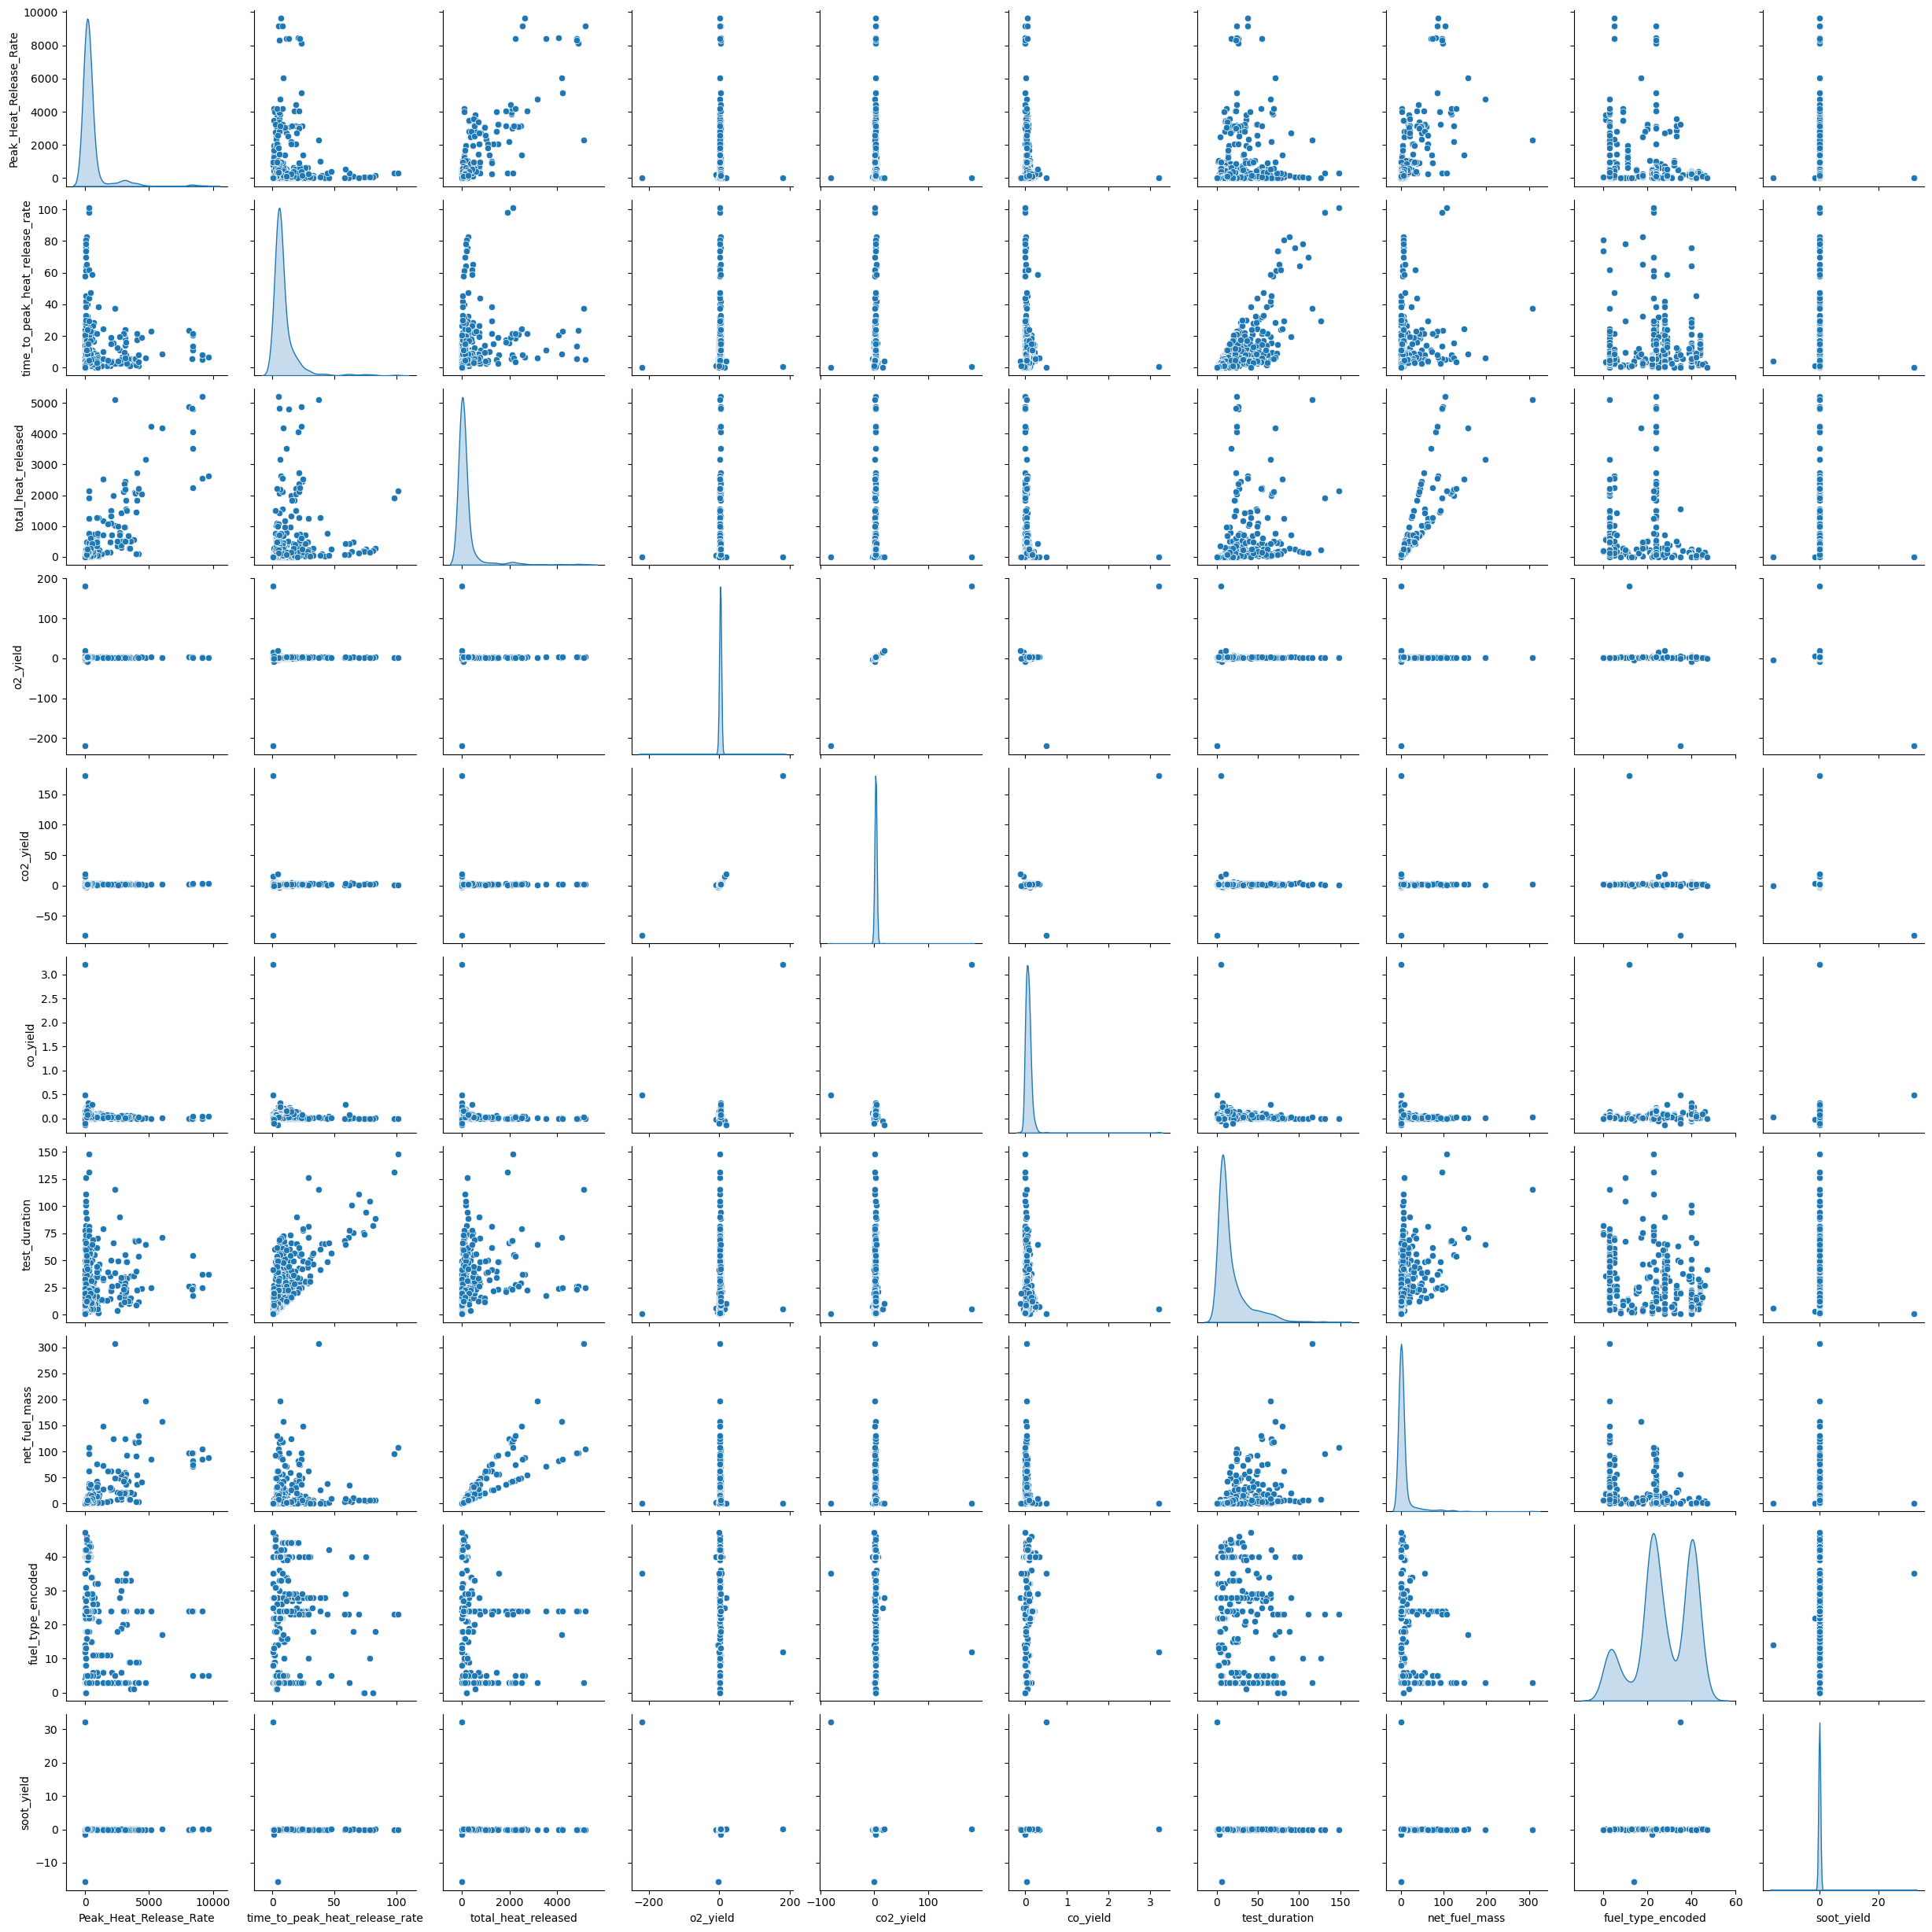

In [106]:
cols = df.columns.tolist()
cols.remove("id")

sns.pairplot(df, vars=cols, diag_kind="kde", palette="husl")
plt.show()

# Plot pairwise relationship in test dataset (before removing outliers or non-physical data)

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


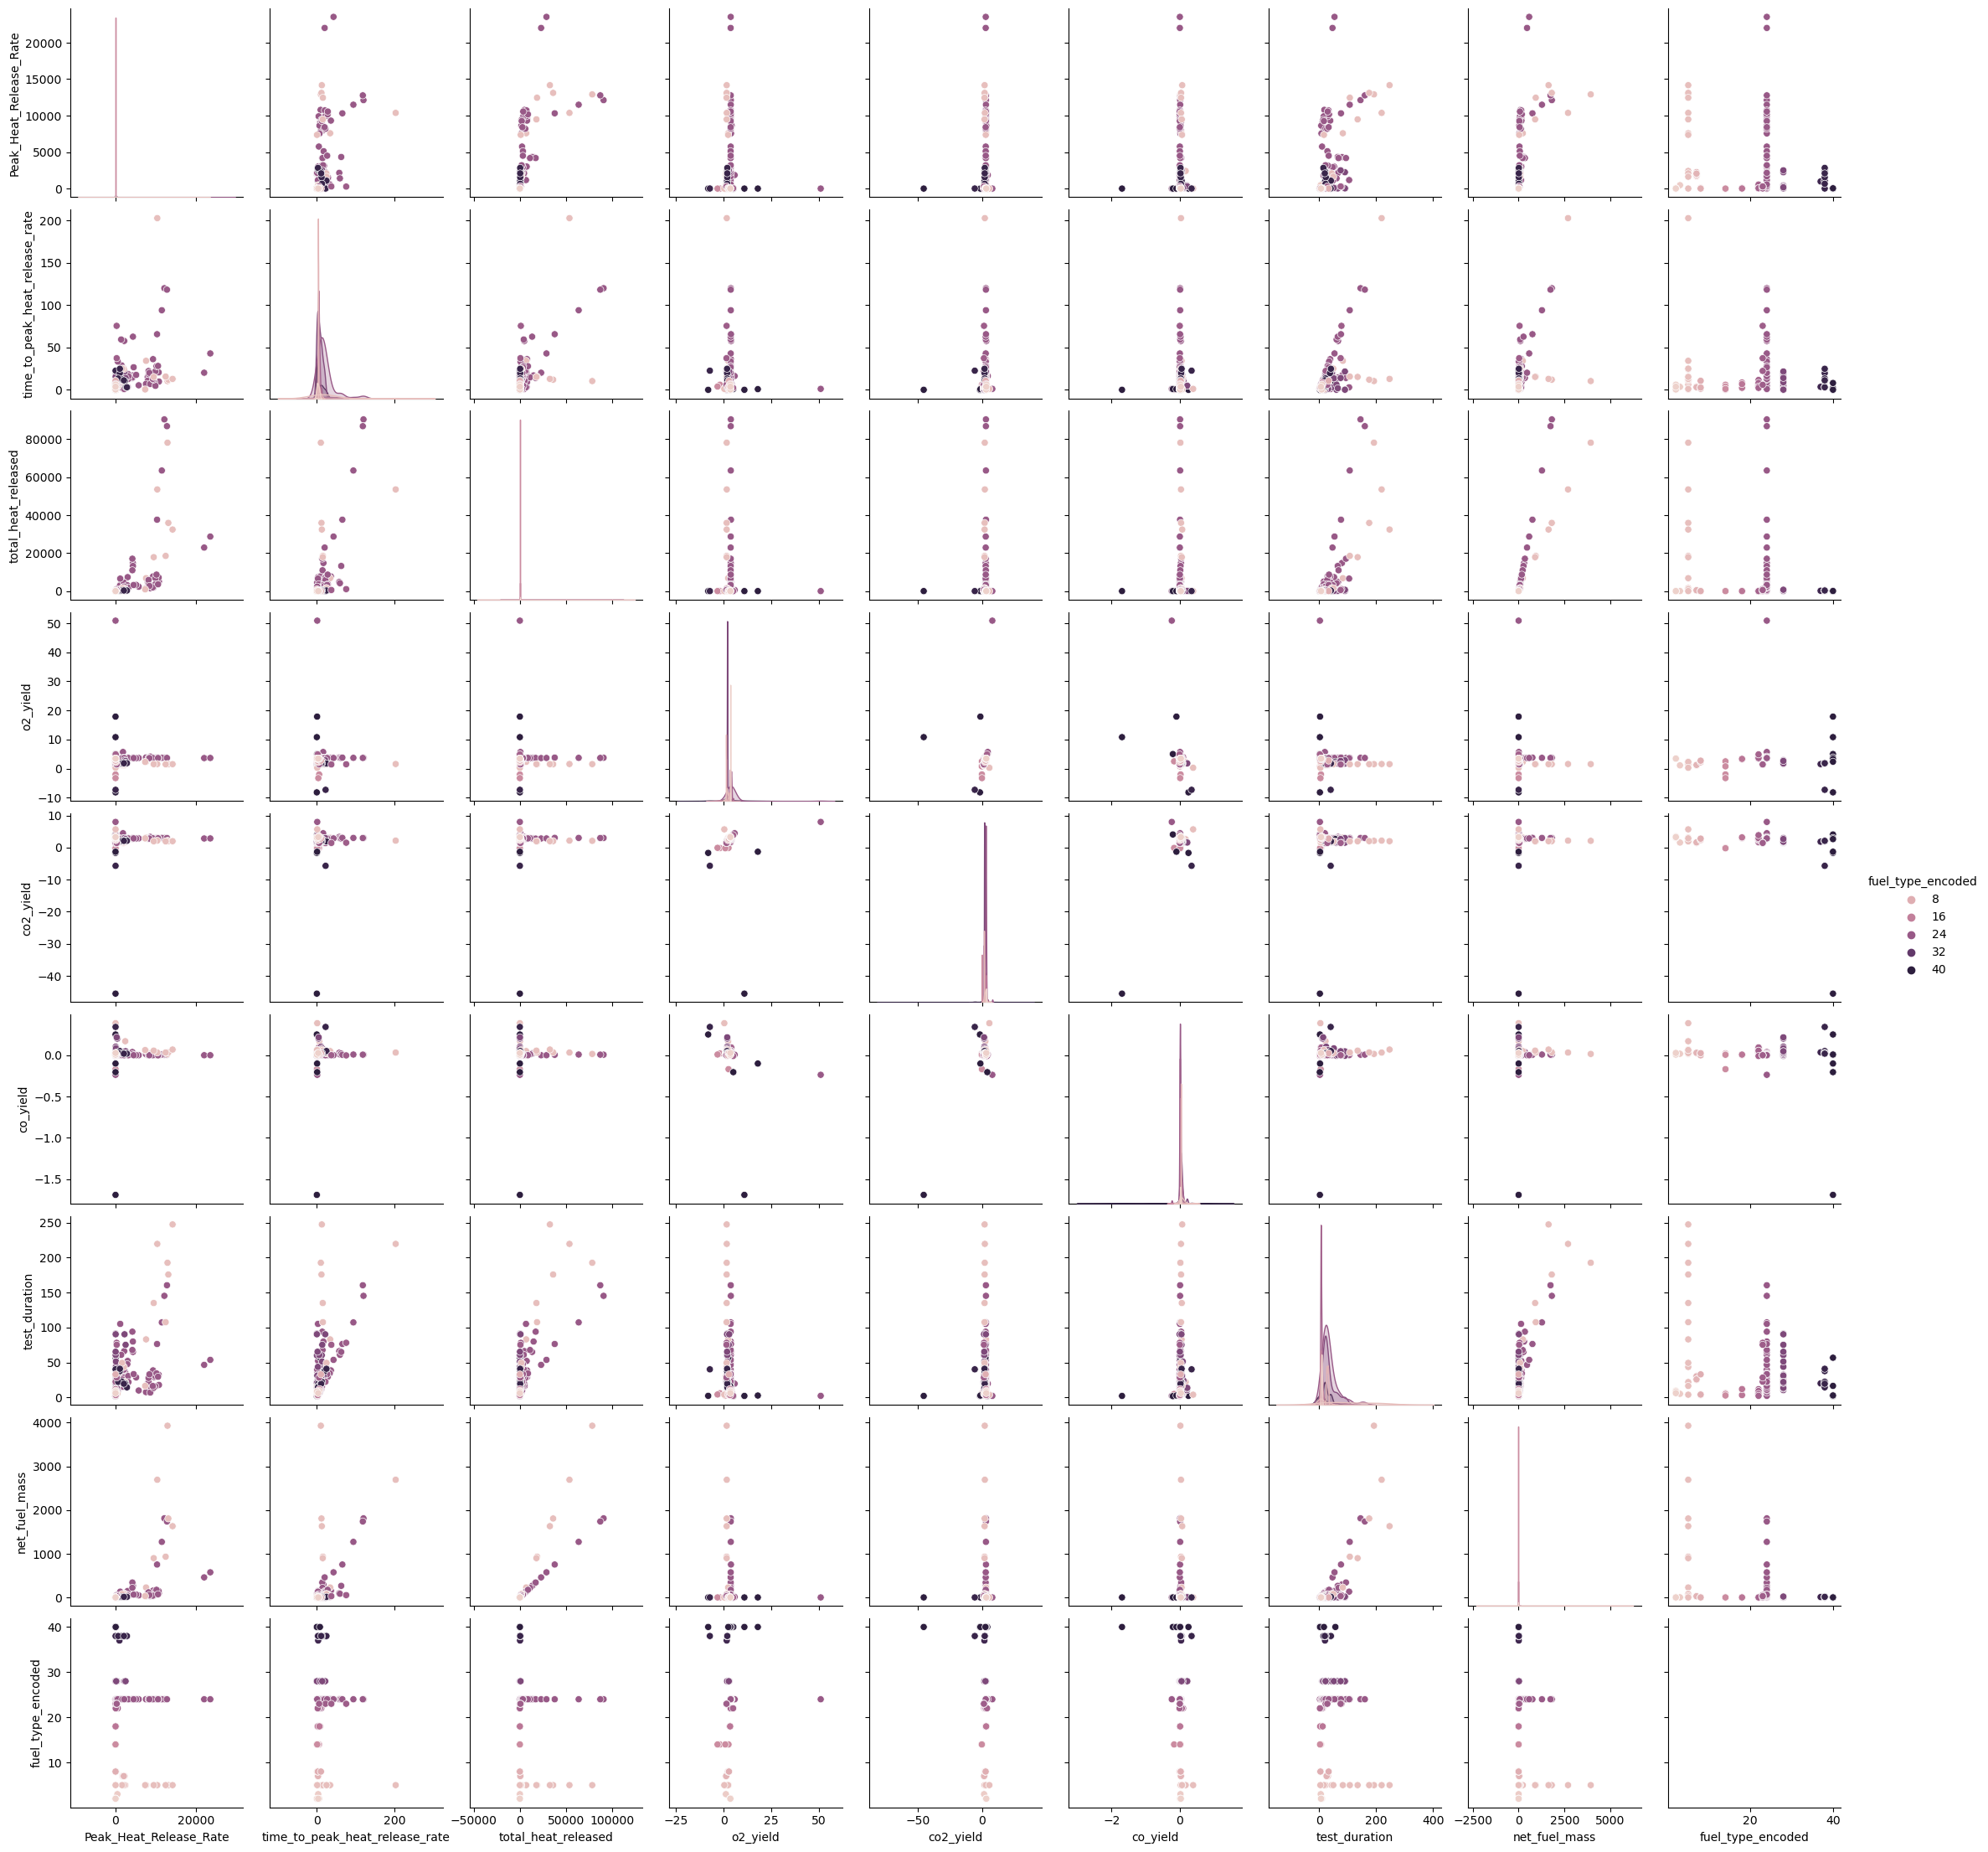

In [107]:
cols = df_test.columns.tolist()
cols.remove("id")
sns.pairplot(df_test, vars=cols, diag_kind="kde", hue="fuel_type_encoded")

# Normalize the input data for Outlier Detection

In [108]:
cols = df.columns.tolist()
cols.remove("id")
cols.remove("soot_yield")
cols.remove("fuel_type_encoded")

#scaler = StandardScaler()
scaler = MinMaxScaler()
X1 = scaler.fit_transform(df[cols])
#print(scaler.mean_, scaler.var_)

#scaler1 = StandardScaler()
scaler1 = MinMaxScaler()
X3 = scaler1.fit_transform(df[["soot_yield"]]).reshape(-1,1)
#print(scaler1.mean_, scaler1.var_)

X2 = df["fuel_type_encoded"].values.reshape(-1,1)

X = np.concatenate((X1,X2), axis=1)
X = np.concatenate((X, X3), axis=1)

X1 = scaler.transform(df_test[cols])
X2 = df_test["fuel_type_encoded"].values.reshape(-1,1)
X_test = np.concatenate((X1,X2), axis=1)

print(f'Shape of X : {np.shape(X)}, Shape of X_test : {np.shape(X_test)}')


Shape of X : (822, 10), Shape of X_test : (189, 9)


# Define a dictionary of outlier detection methods

In [109]:
column_name_list = df.columns.values.tolist()
column_name_list

['id',
 'Peak_Heat_Release_Rate',
 'time_to_peak_heat_release_rate',
 'total_heat_released',
 'o2_yield',
 'co2_yield',
 'co_yield',
 'test_duration',
 'net_fuel_mass',
 'fuel_type_encoded',
 'soot_yield']

# Angle Based Outlier Detection (ABOD)

In [110]:
def abod_analysis(X, contamination):
    table1= PrettyTable(["Dataset #", "ID", "ABOD_Score"])

    for i in range(np.shape(X)[0]):
        X_train = np.delete(X, i, axis = 0)
        X_train_cov = np.cov(X_train, rowvar=False)
        X_test = X[i,:].reshape(1,X.shape[1])

        # train ABOD detector
        clf_name = 'ABOD'
        clf = ABOD(contamination = contamination)
        clf.fit(X_train)

        # get the prediction labels and outlier scores of the training data
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores


        # get the prediction on the test data
        y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
        y_test_scores = clf.decision_function(X_test)  # outlier scores

        if (y_test_pred == 1):
            print("\nDataset # : ", i)
            print("ABOD Score : ", y_test_scores[0])
            print("Dataset id : ", df.iloc[i, 0])
 
            table = PrettyTable(["Column Name", "Value"])
            for j in range(len(column_name_list)):
                table.add_row([column_name_list[j], df.iloc[i,j].round(4) ])
            print(table)
            table1.add_row([i, df.iloc[i, 0], y_test_scores[0] ])

    print("\nOutliers detected by ABOD_outlier_detection")
    table1.sortby="ABOD_Score"
    table1.reversesort=True
    print(table1)
    return                                                                                   

In [111]:
# abod_analysis(X, contamination = 0.002)

# Outlier Detection with Isolation Forest, Ensemble Methods and Boosting Techniques
# Comparison with other un-supervised techniques : KNN, PCA, Clustering, HBOS

In [112]:
def classifier_analysis(X, contamination, df):
    column_name_list = df.columns.values.tolist()
    X_train_cov = np.cov(X, rowvar=False)
    
    classifiers = {
        'PCA' : PCA(contamination=contamination),
        #
        'Local Outlier Factor (LOF)' : LOF(contamination=contamination),
        'Clustering Based Local Outlier Factor (CBLOF)' : CBLOF(contamination=contamination),
        'Histogram Based Outlier Score (HBOS)' : HBOS(contamination=contamination),
        'KNN' : KNN(contamination=contamination, method='largest'),
        'KNN - Median' : KNN(contamination=contamination, method='median'),
        'KNN-Mahalanobis' :  KNN(contamination = contamination, metric = 'mahalanobis',
                                  metric_params={'V': X_train_cov}),

        #
        'Angle Based Outlier Detection (ABOD)': ABOD(contamination=contamination),
        #
        'Isolation Forest - IForest' : IForest(contamination = contamination),
        'Bag' : FeatureBagging(contamination = contamination),
        
        ###'Boosting' : XGBOD(contamination = contamination),
        #
        #'AutoEncoder' : AutoEncoder(hidden_neurons=[8,4,2,4,8], contamination = contamination),
        #'VAE' : VAE(encoder_neurons=[7,5,3], decoder_neurons=[3,5,7], contamination = contamination)
    }
    y_test_pred_dir = {}
    y_test_scores_dir= {}

    for clf_name, clf in classifiers.items():

        table1= PrettyTable(["Dataset #", "ID", "Score"])
        y_test_pred_dir[clf_name]=[]
        y_test_scores_dir[clf_name]=[]

        for i in range(X.shape[0]):
            X_train = np.delete(X,  i, axis = 0)
            X_train_cov = np.cov(X_train, rowvar=False)
            X_test  = X[i,:].reshape(1, X.shape[1])
            
            clf.fit(X_train)
            
            # get the prediction labels and outlier scores of the training data
            y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
            y_train_scores = clf.decision_scores_  # raw outlier scores


            # get the prediction on the test data
            y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
            y_test_scores = clf.decision_function(X_test)  # outlier scores
            
            y_test_pred_dir[clf_name].append(y_test_pred)
            y_test_scores_dir[clf_name].append(y_test_scores)

            if (y_test_pred == 1):
                table = PrettyTable(["Column Name", "Value"])
                for j in range(len(column_name_list)):
                    table.add_row([column_name_list[j], df.iloc[i,j].round(4)])
                #print(table)
                
                table1.add_row([i, df.iloc[i, 0], y_test_scores[0] ])
            
        print("\nOutliers detected by classifier : ", clf_name)
        table1.sortby="Score"
        table1.reversesort=True
        print(table1)
    return y_test_pred_dir, y_test_scores_dir

In [113]:
(y_test_pred_dir, y_test_scores_dir) = classifier_analysis(X, contamination=0.002, df=df)


Outliers detected by classifier :  PCA
+-----------+------------+--------------------+
| Dataset # |     ID     |       Score        |
+-----------+------------+--------------------+
|    810    | 1620136548 | 154285.40488231403 |
|    729    | 1534512745 | 72571.96301956664  |
+-----------+------------+--------------------+

Outliers detected by classifier :  Local Outlier Factor (LOF)
+-----------+------------+--------------------+
| Dataset # |     ID     |       Score        |
+-----------+------------+--------------------+
|    119    | 1612537018 | 115.28806217899712 |
|    113    | 1613586143 | 113.34221172503894 |
|    118    | 1612883417 | 111.36186262351728 |
+-----------+------------+--------------------+

Outliers detected by classifier :  Clustering Based Local Outlier Factor (CBLOF)
+-----------+------------+-------------------+
| Dataset # |     ID     |       Score       |
+-----------+------------+-------------------+
|    764    | 1574188624 |  9.43322527394551 |
|  

# Detecting outliers in Test Data

In [114]:
(y_test_pred_dir_, y_test_scores_dir_) = classifier_analysis(X_test, contamination=0.002, df=df_test)


Outliers detected by classifier :  PCA
+-----------+------------+--------------------+
| Dataset # |     ID     |       Score        |
+-----------+------------+--------------------+
|     10    | 1638288179 | 13225.273130877806 |
|     1     | 1643825175 | 7901.572735773164  |
+-----------+------------+--------------------+

Outliers detected by classifier :  Local Outlier Factor (LOF)
+-----------+----+-------+
| Dataset # | ID | Score |
+-----------+----+-------+
+-----------+----+-------+

Outliers detected by classifier :  Clustering Based Local Outlier Factor (CBLOF)
+-----------+------------+--------------------+
| Dataset # |     ID     |       Score        |
+-----------+------------+--------------------+
|    154    | 1492523586 | 19.258318063582223 |
+-----------+------------+--------------------+

Outliers detected by classifier :  Histogram Based Outlier Score (HBOS)
+-----------+------------+-------------------+
| Dataset # |     ID     |       Score       |
+-----------

In [115]:
def classifier_analysis_fast(X, contamination, df):
    column_name_list = df.columns.values.tolist()
    X_train_cov = np.cov(X, rowvar=False)
    
    classifiers = {
        'PCA' : PCA(contamination=contamination),
        #
        'Local Outlier Factor (LOF)' : LOF(contamination=contamination),
        'Clustering Based Local Outlier Factor (CBLOF)' : CBLOF(contamination=contamination),
        'Histogram Based Outlier Score (HBOS)' : HBOS(contamination=contamination),
        'KNN' : KNN(contamination=contamination, method='largest'),
        'KNN-Median' : KNN(contamination=contamination, method='median'),
        'KNN-Mahalanobis' :  KNN(contamination = contamination, metric = 'mahalanobis',
                                  metric_params={'V': X_train_cov}),

        #
        'Angle Based Outlier Detection - ABOD': ABOD(contamination=contamination),
        #
        'Isolation Forest - IForest' : IForest(contamination = contamination),
        'Bag' : FeatureBagging(contamination = contamination),
        ### 'Boosting' : XGBOD(estimator_list=[LOF], contamination = contamination),
        #
        'AutoEncoder' : AutoEncoder(hidden_neurons=[8,4,2,4,8], contamination = contamination),
        'Variational AutoEncoders' : VAE(encoder_neurons=[7,5,3], decoder_neurons=[3,5,7], contamination = contamination)
    }
    for clf_name, clf in classifiers.items():

        table1= PrettyTable(["Dataset #", "ID", "Score"])
        
        clf.fit(X)
            
        # get the prediction labels and outlier scores of the training data
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        for i in range(X.shape[0]):        

            if (y_train_pred[i] == 1):
                table = PrettyTable(["Column Name", "Value"])
                for j in range(len(column_name_list)):
                    table.add_row([column_name_list[j], df.iloc[i,j].round(4)])
                #print(table)
                
                table1.add_row([i, df.iloc[i, 0], y_train_scores[i] ])
            
        print("\nOutliers detected by classifier : ", clf_name)
        table1.sortby="Score"
        table1.reversesort=True
        print(table1)
    return

In [116]:
classifier_analysis_fast(X, contamination=0.002, df = df)


Outliers detected by classifier :  PCA
+-----------+------------+--------------------+
| Dataset # |     ID     |       Score        |
+-----------+------------+--------------------+
|    729    | 1534512745 | 33915.93514272887  |
|    810    | 1620136548 | 30625.490745497846 |
+-----------+------------+--------------------+

Outliers detected by classifier :  Local Outlier Factor (LOF)
+-----------+------------+--------------------+
| Dataset # |     ID     |       Score        |
+-----------+------------+--------------------+
|    119    | 1612537018 | 112.55177521318755 |
|    113    | 1613586143 | 110.65498157794211 |
+-----------+------------+--------------------+

Outliers detected by classifier :  Clustering Based Local Outlier Factor (CBLOF)
+-----------+------------+-------------------+
| Dataset # |     ID     |       Score       |
+-----------+------------+-------------------+
|    764    | 1574188624 | 8.783187860956994 |
|    762    | 1574181676 | 8.783073378718985 |
+---

In [117]:
classifier_analysis_fast(X_test, contamination=0.002, df = df_test)


Outliers detected by classifier :  PCA
+-----------+------------+-------------------+
| Dataset # |     ID     |       Score       |
+-----------+------------+-------------------+
|     10    | 1638288179 | 5797.028700512288 |
+-----------+------------+-------------------+

Outliers detected by classifier :  Local Outlier Factor (LOF)
+-----------+------------+--------------------+
| Dataset # |     ID     |       Score        |
+-----------+------------+--------------------+
|    104    | 1470060782 | 19.257451390787505 |
+-----------+------------+--------------------+

Outliers detected by classifier :  Clustering Based Local Outlier Factor (CBLOF)
+-----------+------------+--------------------+
| Dataset # |     ID     |       Score        |
+-----------+------------+--------------------+
|    154    | 1492523586 | 19.258318063582223 |
+-----------+------------+--------------------+

Outliers detected by classifier :  Histogram Based Outlier Score (HBOS)
+-----------+------------+-

# Visualizing Outliers

In [118]:
def visualization(X, dfx, var1, var2):
    random_state = np.random.RandomState(42)
    outliers_fraction = 0.05
    # Define seven outlier detection tools to be compared
    classifiers = {
            'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
            'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
            'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
            'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
            'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
            'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
            'Average KNN': KNN(method='mean',contamination=outliers_fraction)
    }
    
    xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        plt.figure(figsize=(10, 10))

        # copy of dataframe
        dfx['outlier'] = y_pred.tolist()
        
        #IX1 - inlier feature 1,  IX2 - inlier feature 2
        IX1 = np.ma.masked_where(dfx['outlier'] == 1, X[:,0])
        IX2 = np.ma.masked_where(dfx['outlier'] == 1, X[:,1])
        #print(IX1.shape, IX2.shape)

        # OX1 - outlier feature 1, OX2 - outlier feature 2
        OX1 = np.ma.masked_where(dfx['outlier'] == 0, X[:,0])
        OX2 = np.ma.masked_where(dfx['outlier'] == 0, X[:,1])

        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

        # threshold value to consider a datapoint inlier or outlier
        threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)

        # decision function calculates the raw anomaly score for every point
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        
        # fill blue map colormap from minimum anomaly score to threshold value
        plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

        # draw red contour line where anomaly score is equal to thresold
        a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

        # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
        plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

        b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
        c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
        plt.axis('tight')  
        
        # loc=2 is used for the top left corner 
        
        plt.legend(
            [a.collections[0], b,c],
            ['learned decision function', 'inliers','outliers'],
            prop=matplotlib.font_manager.FontProperties(size=14),
            loc=2)

        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.title(clf_name, fontsize=18)
        plt.xlabel(var1, fontsize=14)
        plt.ylabel(var2, fontsize=14)

        figname = 'fig'+str(i)+'.jpg'
        plt.savefig(figname)
        
        plt.show()
    return



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  40 INLIERS :  782 Angle-based Outlier Detector (ABOD)


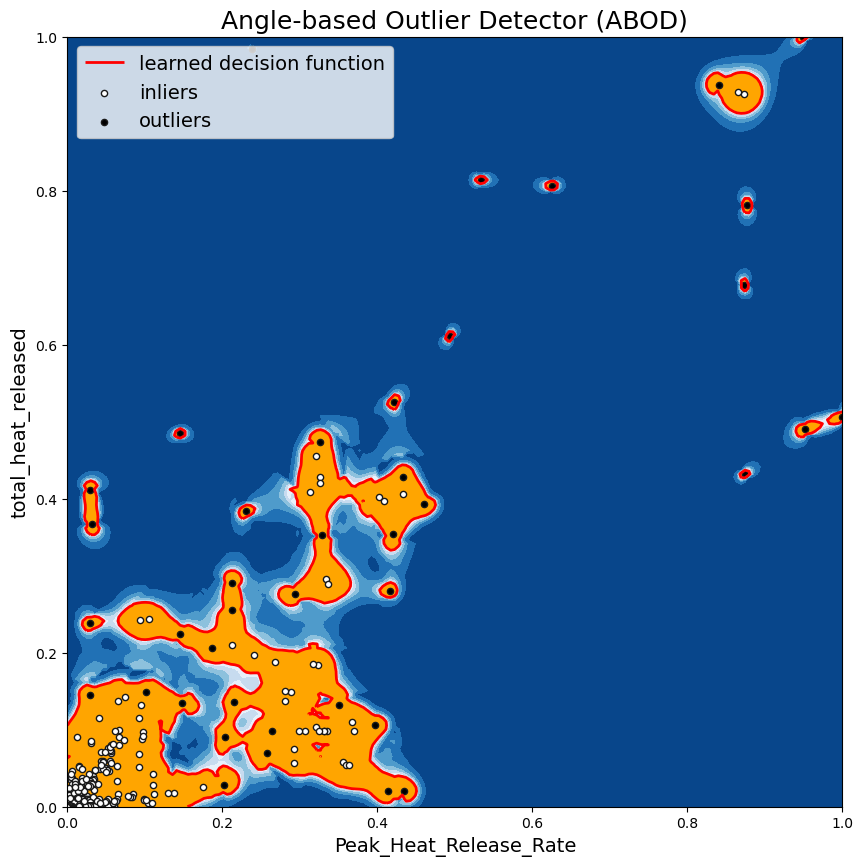


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  42 INLIERS :  780 Cluster-based Local Outlier Factor (CBLOF)


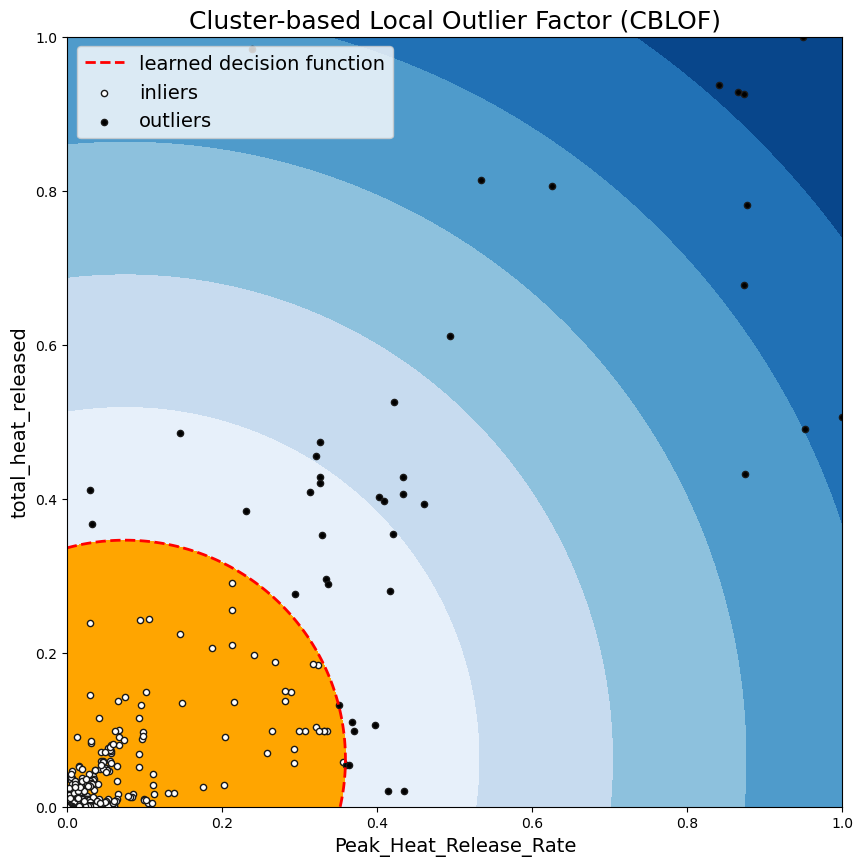


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  37 INLIERS :  785 Feature Bagging


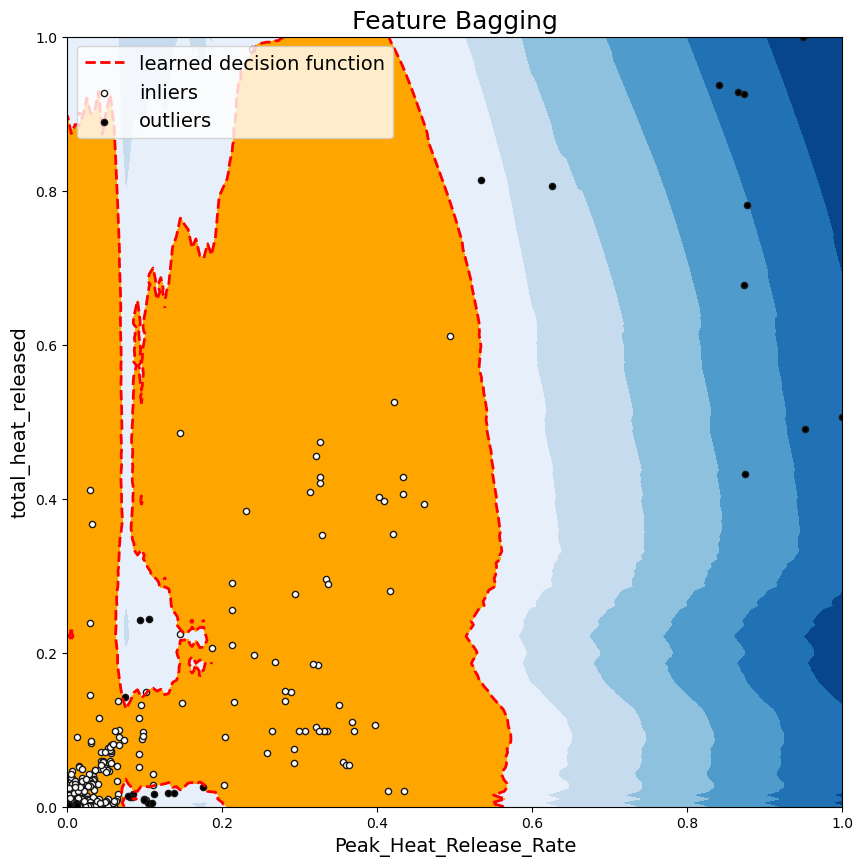


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  40 INLIERS :  782 Histogram-base Outlier Detection (HBOS)


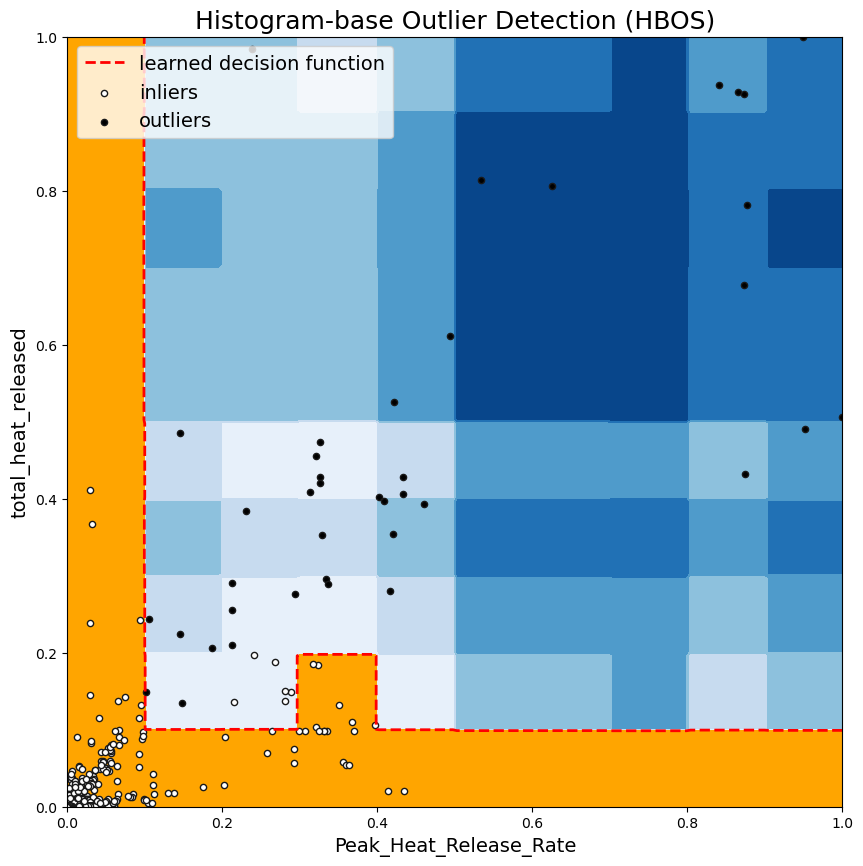


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  42 INLIERS :  780 Isolation Forest


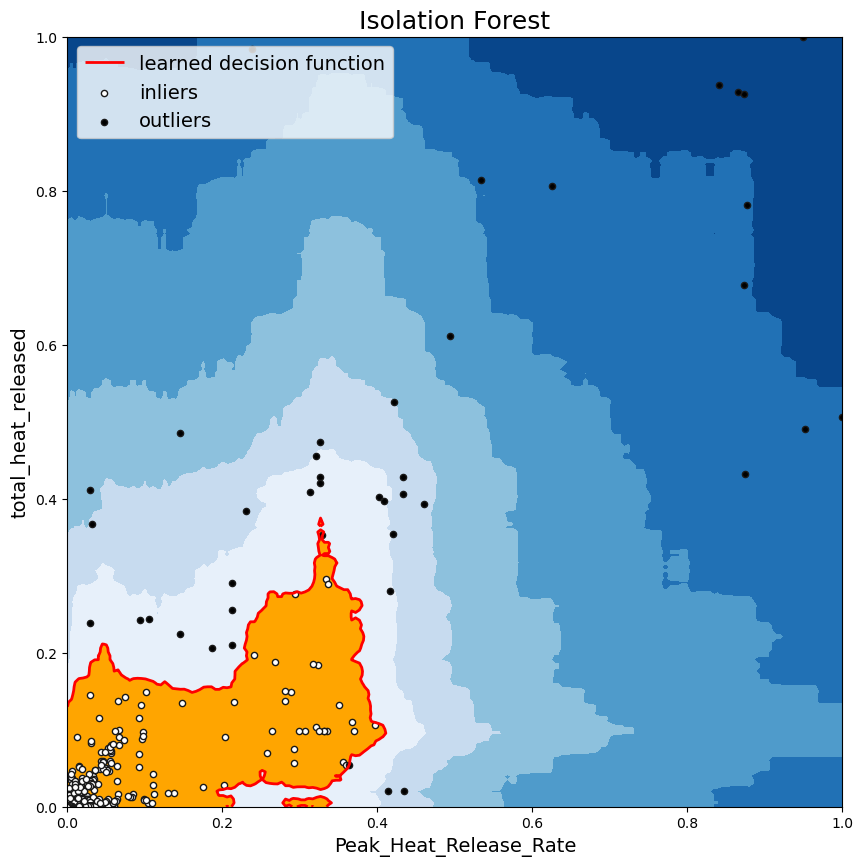


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  31 INLIERS :  791 K Nearest Neighbors (KNN)


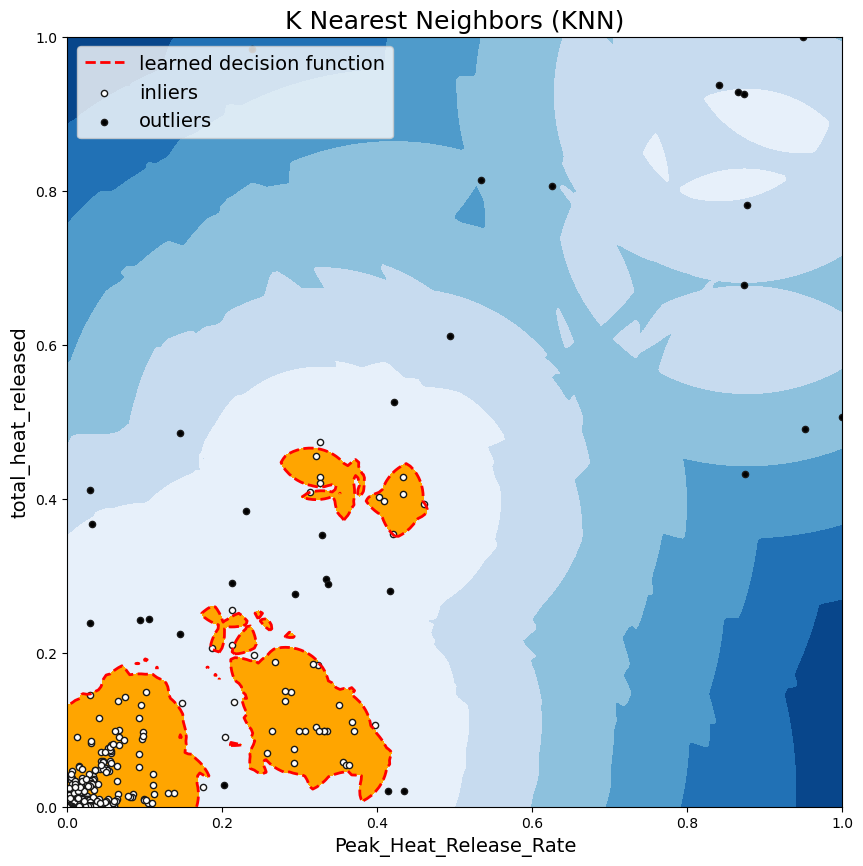


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  25 INLIERS :  797 Average KNN


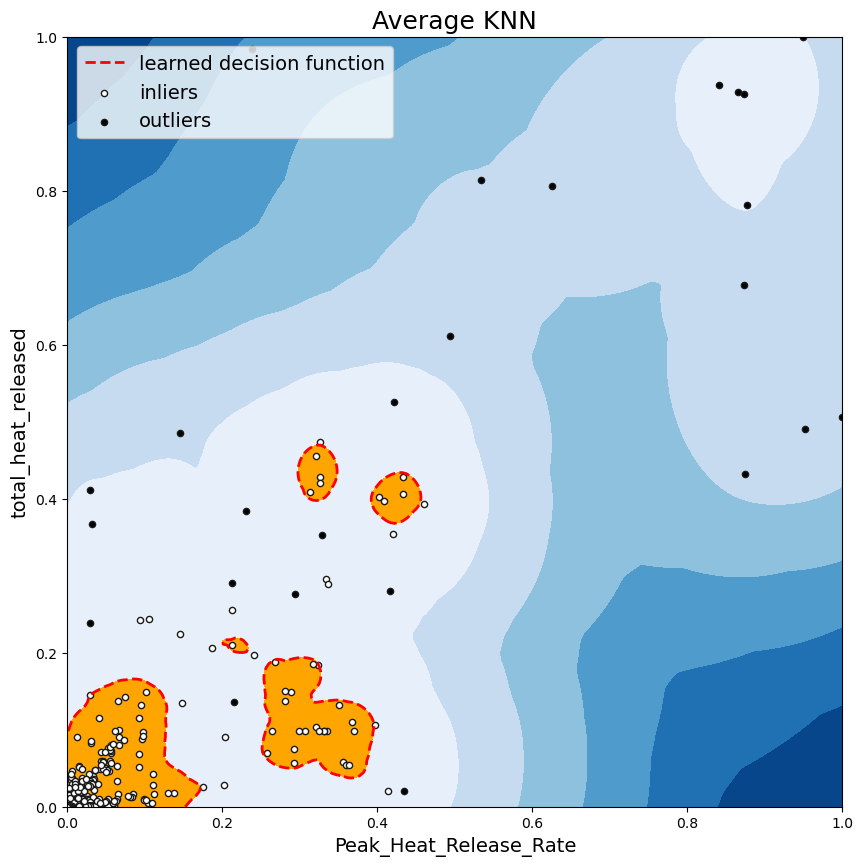

In [119]:
X1 = np.concatenate((X[:,0].reshape(-1,1), X[:,2].reshape(-1,1)), axis=1)
var1 = 'Peak_Heat_Release_Rate'
var2 = 'total_heat_released'
df1 =  df[[var1, var2]]
visualization(X1, df1, var1, var2)

# Visualizing the Outliers in the Dataset using Pairplots

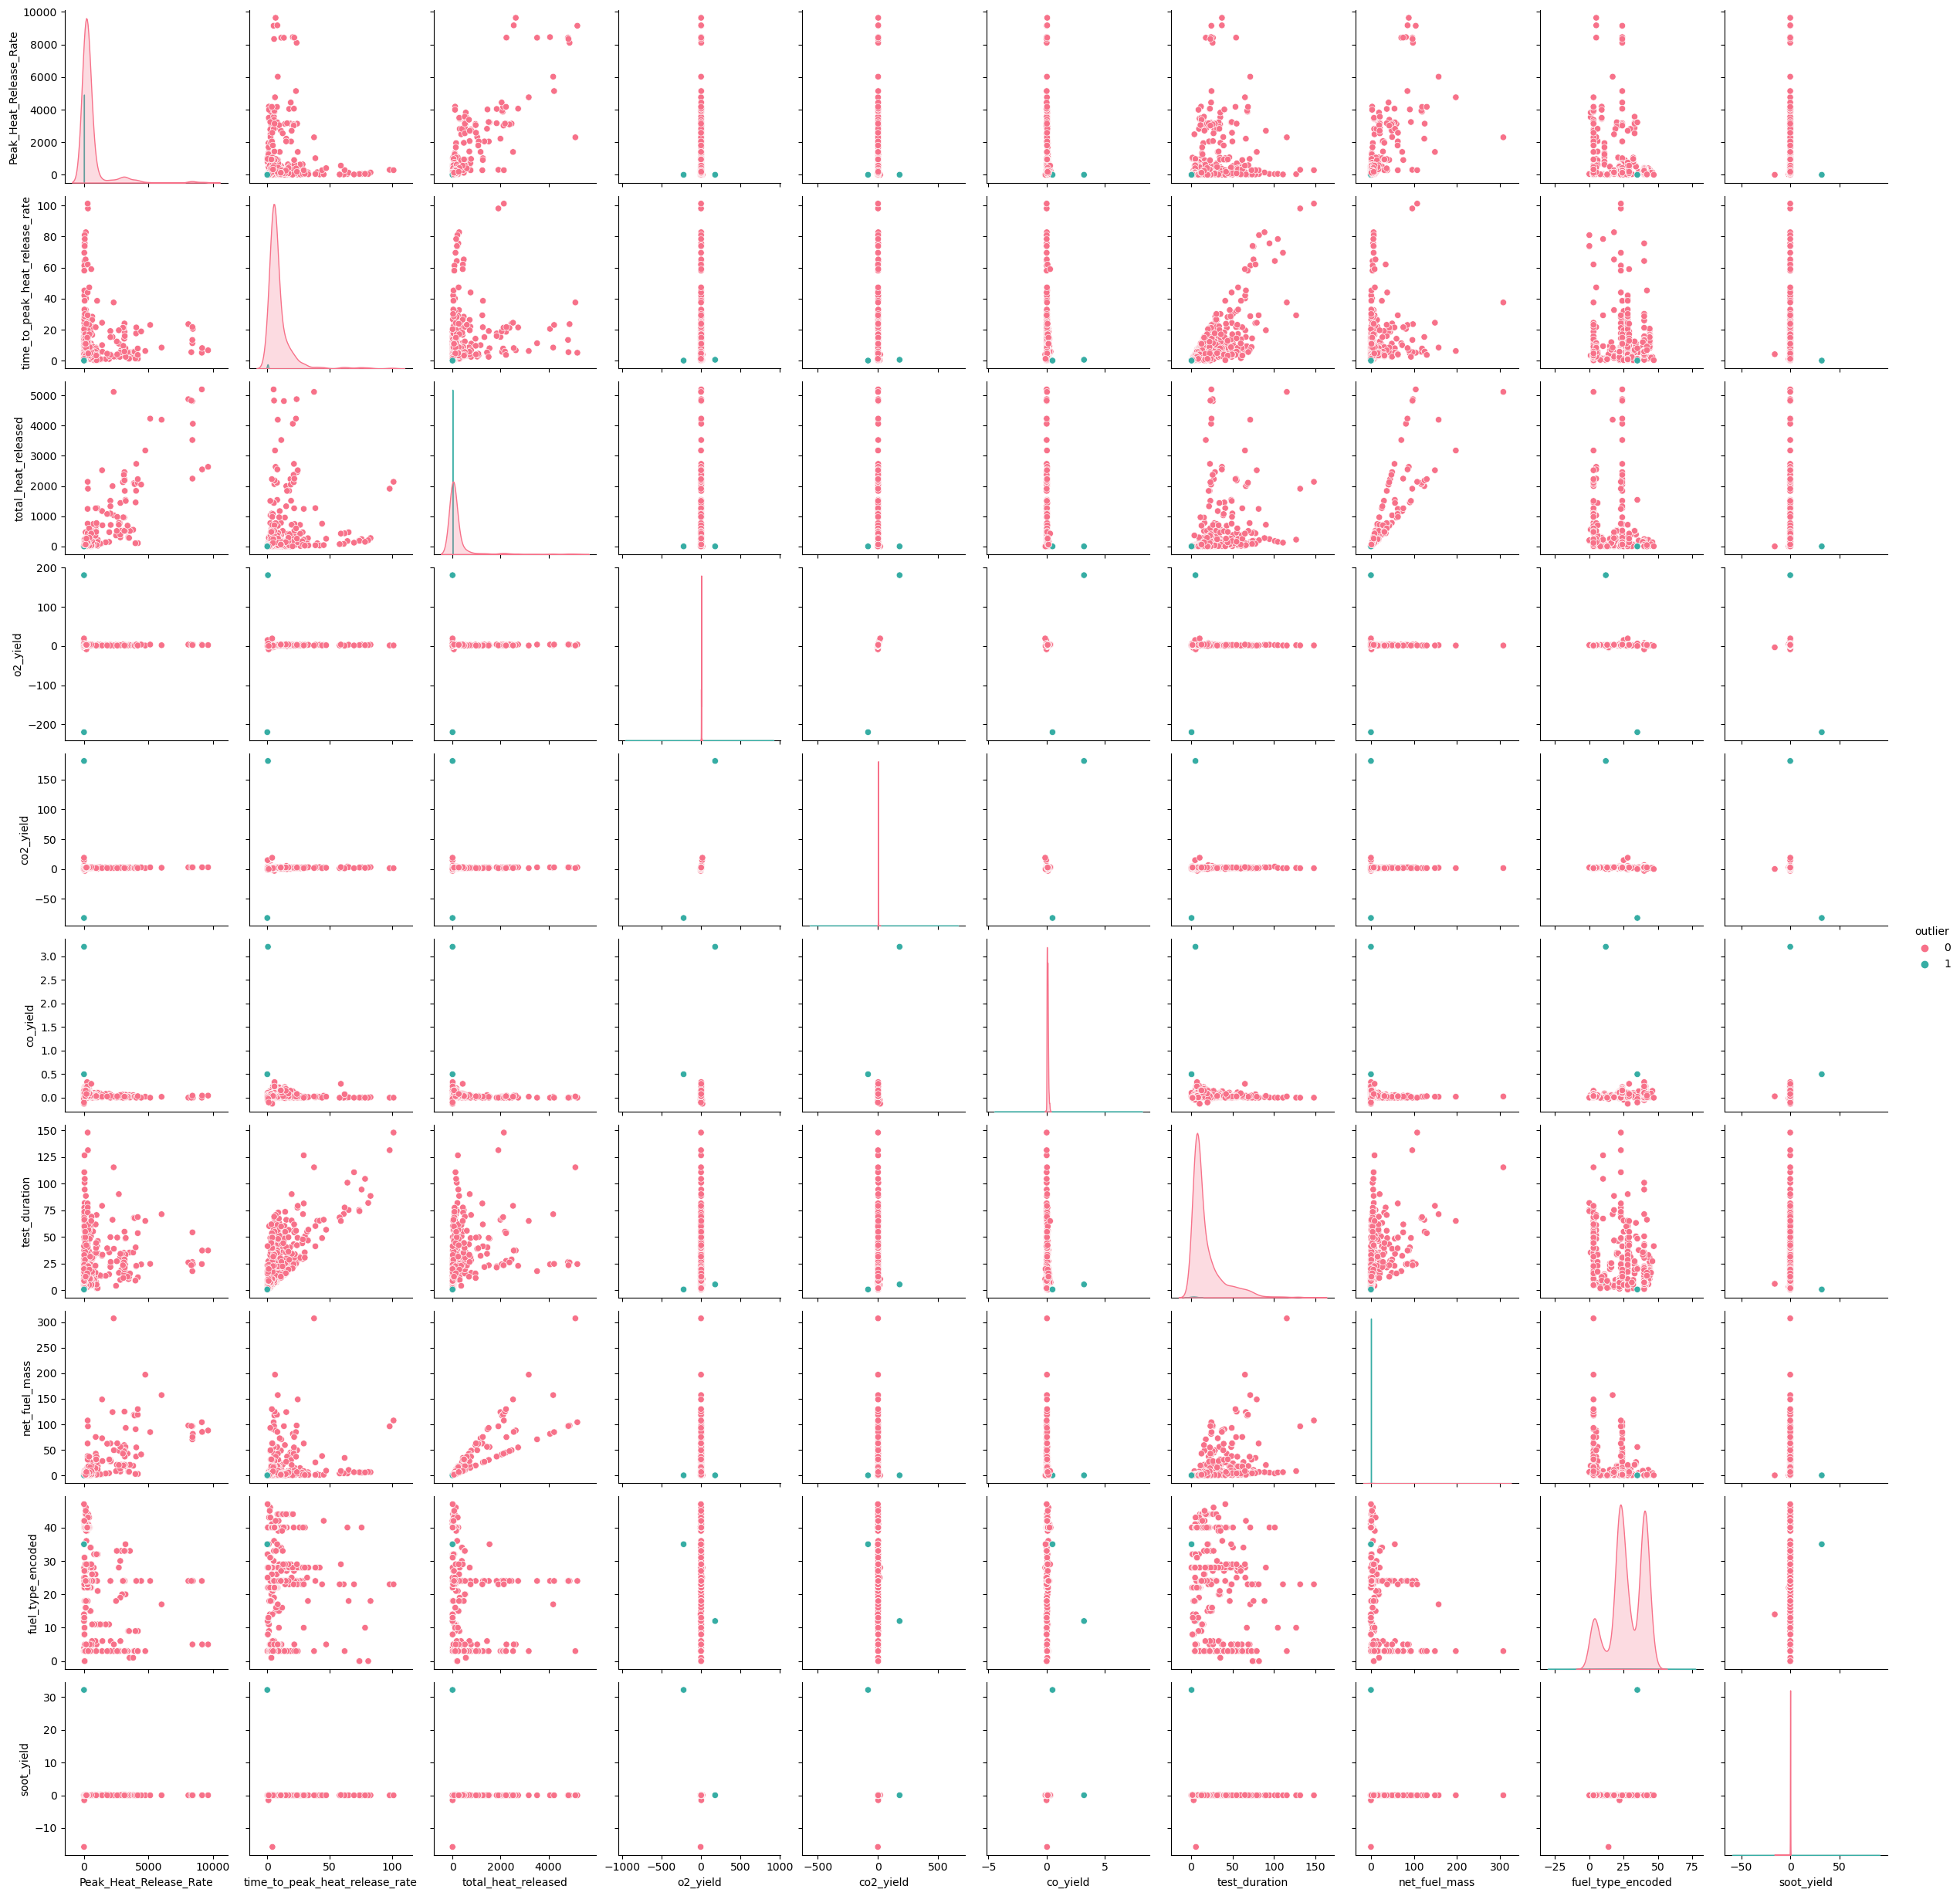

In [120]:

df['outlier']=y_test_pred_dir['PCA']
df['outlier']= df['outlier'].astype(int)

cols = df.columns.tolist()
cols.remove("id")
cols.remove("outlier")

sns.pairplot(df, vars=cols, diag_kind="kde", palette="husl", hue="outlier")
df.drop(['outlier'], axis=1, inplace=True)
plt.show()

# Remove Outliers from the Dataset

In [121]:
print(f'Shape of the Dataframe before removing outliers : {df.shape}')
outlier_exp_ids = [1620136548, 1534512745]

for outlier_exp_id in outlier_exp_ids:
    df = df[df["id"] != outlier_exp_id]
    
print(f'Shape of the Dataframe after removing outliers : {df.shape}')

Shape of the Dataframe before removing outliers : (822, 11)
Shape of the Dataframe after removing outliers : (820, 11)


# Removing datapoints that do not make physical sense (Domain knowledge)

In [122]:
print(f'Shape of the Dataframe before removing outliers : {df.shape}')

#df = df[df["o2_yield"]   >= 0.0]
#df = df[df["co2_yield"]  >= 0.0]
#df = df[df["co_yield"]   >= 0.0]
#df = df[df["soot_yield"] >= 0.0]
    
print(f'Shape of the Dataframe after removing outliers : {df.shape}')

Shape of the Dataframe before removing outliers : (820, 11)
Shape of the Dataframe after removing outliers : (820, 11)


# Visualizing the final dataset without outliers

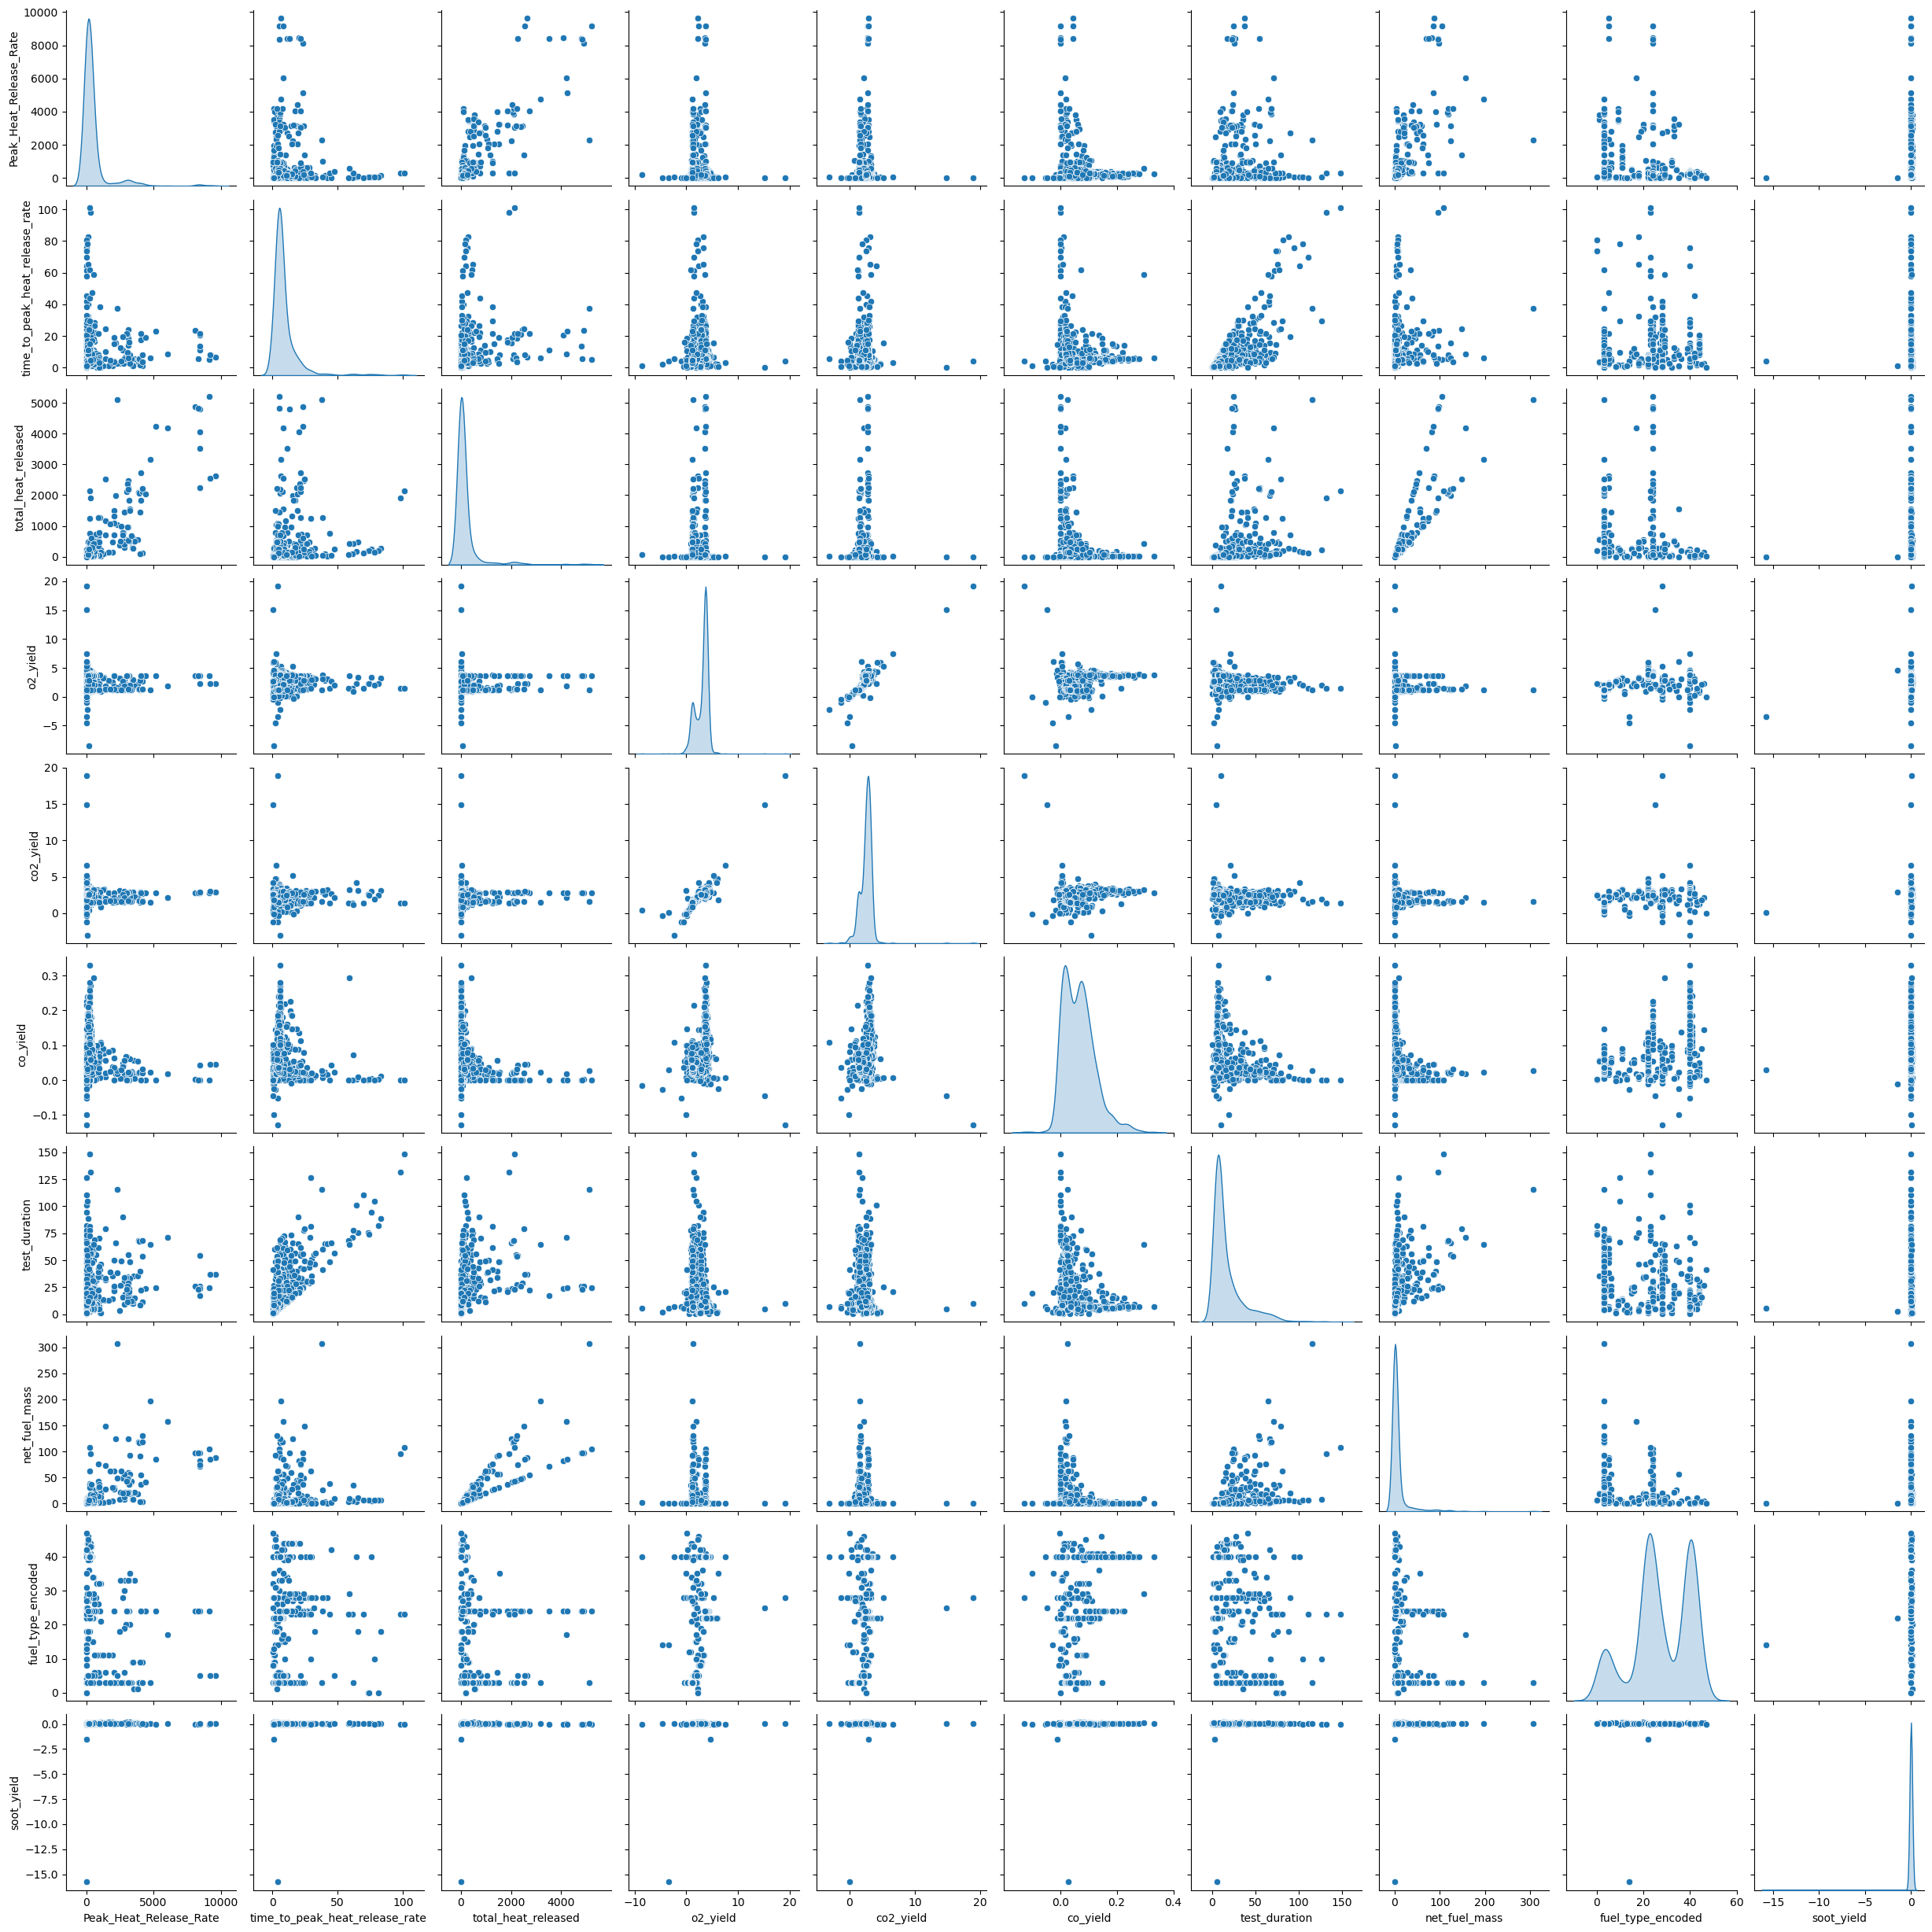

In [123]:
cols = df.columns.tolist()
cols.remove("id")

sns.pairplot(df, vars=cols, diag_kind="kde", palette="husl")
plt.show()

In [124]:
# Removing the datapoints in the test set that do no make physical sense

In [125]:
print(f'Shape of the Dataframe before removing outliers : {df_test.shape}')

#df_test = df_test[df_test["o2_yield"] >= 0.0]
#df_test = df_test[df_test["co2_yield"] >= 0.0]
#df_test = df_test[df_test["co_yield"] >= 0.0]

print(f'Shape of the Dataframe after removing outliers : {df_test.shape}')

Shape of the Dataframe before removing outliers : (189, 10)
Shape of the Dataframe after removing outliers : (189, 10)


<AxesSubplot:>

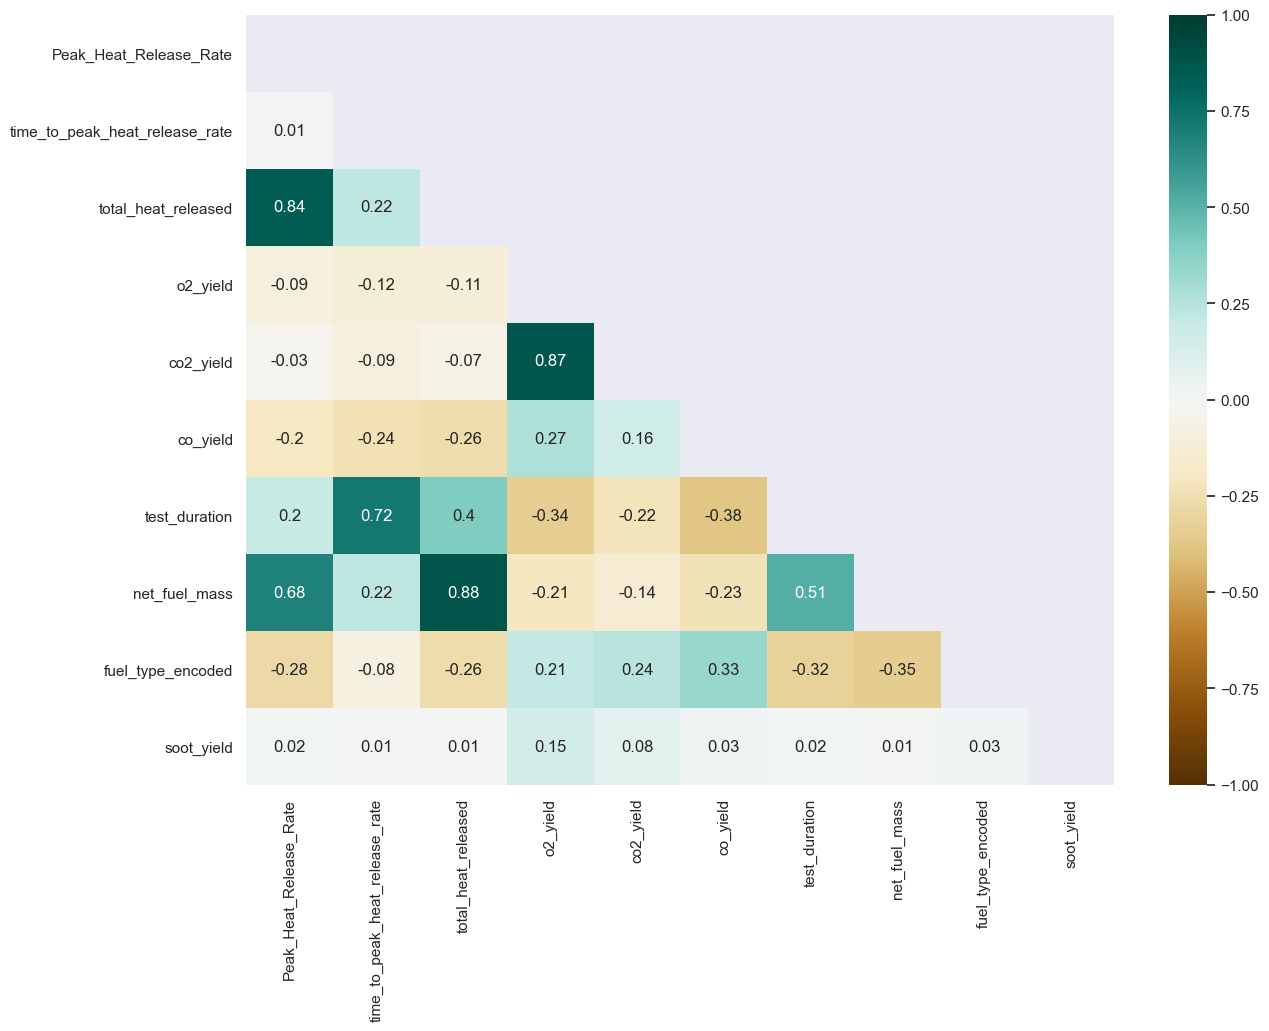

In [126]:
# Make covariance plot
cov_matrix = df.iloc[:,1:].corr().round(2)
mask = np.triu(np.ones_like(cov_matrix, dtype=bool))
sns.set(rc = {'figure.figsize':(14,10)})
sns.heatmap(cov_matrix, annot=True, mask=mask, vmin=-1, vmax=1, cmap='BrBG')


# Features are not highly correlated with each other (good news!)

<AxesSubplot:xlabel='fuel_type_encoded', ylabel='Peak_Heat_Release_Rate'>

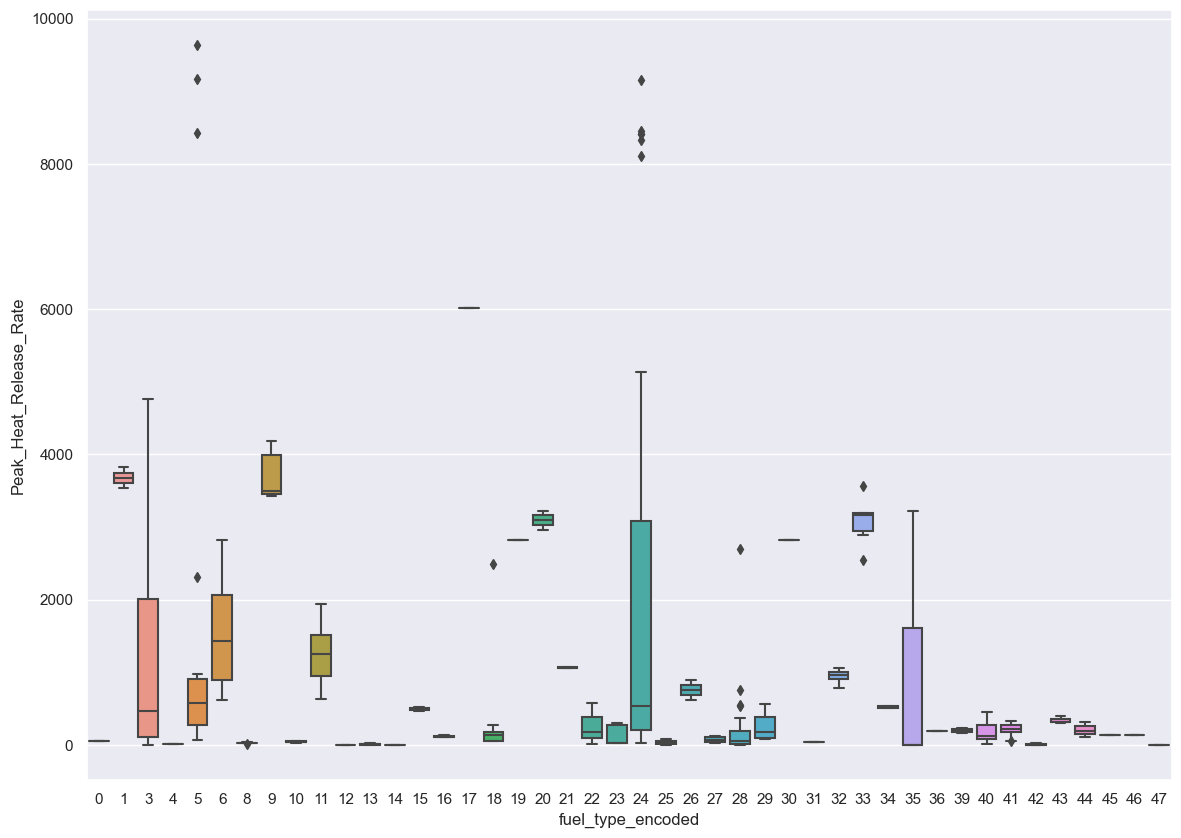

In [127]:
# sns boxplot
cols = df.columns.to_list()
cols.remove("id")
cols.remove("fuel_type_encoded")
sns.boxplot(x = 'fuel_type_encoded', y = 'Peak_Heat_Release_Rate', data = df)

# For Fire Scientists, Peak Heat Release Rate is a critical measurement. We choose to estimate peak heat release rate using ML/AI techniques

## Use a Baseline Linear Regression Model to Estimate Peak Heat Release Rate

In [128]:
def prediction_plot(y_train_pred, plot_title):
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams['figure.figsize']=[6,6]
    plt.plot(y_train, y_train_pred, 'ro', label='Predictions')
    plt.plot([0,10000], [0,10000], 'k-', label='1:1 line')
    plt.xlabel('Peak Heat Release Rate (Measured)', fontsize=14)
    plt.ylabel('Peak Heat Release Rate (Predicted)', fontsize=14)
    plt.title(plot_title, fontsize=20)
    plt.legend()
    plt.show()
    return

In [129]:
# Feature Engineering based on Domain Knowledge
df['HOCF']=df['total_heat_released']/df['net_fuel_mass']
df_test['HOCF']=df_test['total_heat_released']/df_test['net_fuel_mass']

In [130]:
df.head()

id  Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0  1647008482                   96.46                           21.45   
1  1646936290                  127.17                           11.38   
2  1646410394                   44.72                           15.55   
3  1646317604                  279.98                            9.73   
4  1646236342                  476.98                           18.90   

   total_heat_released  o2_yield  co2_yield  co_yield  test_duration  \
0            173.80297  1.215211   1.020752  0.112912      55.816667   
1            126.85369  1.312967   1.157866  0.087455      39.666667   
2             36.46506  1.229338   1.100835  0.026711      26.150000   
3            199.53617  2.901444   2.641933  0.094687      33.750000   
4            260.05008  2.824405   2.586653  0.020452      34.866667   

   net_fuel_mass  fuel_type_encoded  soot_yield  HOCF  
0      10.284199                 27    0.009760  16.9  
1       7.506136                 27    0.018994  16.9  
2       2.157696                 27    0.011638  16.9  
3       4.988404                 29    0.039490  40.0  
4       6.501252                 29    0.052682  40.0

In [131]:
X_train = df.drop(["id", "Peak_Heat_Release_Rate"], axis = 1).values
y_train = df["Peak_Heat_Release_Rate"]

method_R2_Score = {}

In [132]:
X_train.shape, y_train.shape, np.max(X_train), np.min(X_train)

((820, 10), (820,), 5203.210199999992, -15.778331993204228)

In [133]:
# Build a pipeline
pipe = Pipeline([ ('scaler', StandardScaler()), ('linregmodel', Ridge(solver='svd')) ])
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'linregmodel', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'linregmodel__alpha', 'linregmodel__copy_X', 'linregmodel__fit_intercept', 'linregmodel__max_iter', 'linregmodel__normalize', 'linregmodel__random_state', 'linregmodel__solver', 'linregmodel__tol'])

In [134]:
# Hyper-parameters tuning 
param = {'linregmodel__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000, 100000]}
gs = GridSearchCV(estimator = pipe, param_grid =  param, scoring="r2", n_jobs=-1, refit=True, cv=10, return_train_score=True)

In [135]:
# Fit the model
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('linregmodel', Ridge(solver='svd'))]),
             n_jobs=-1,
             param_grid={'linregmodel__alpha': [0.001, 0.01, 0.1, 1.0, 10.0,
                                                100.0, 1000.0, 10000, 100000]},
             return_train_score=True, scoring='r2')

In [136]:
print(f'Cross Validation  Mean R2 Score : {np.mean(gs.cv_results_["mean_test_score"] ).round(4) }')

Cross Validation  Mean R2 Score : -1.0876


In [137]:
print(f'Training Mean R2 Score : {np.mean(gs.cv_results_["mean_train_score"] ).round(4) }') 

Training Mean R2 Score : 0.59


In [138]:
# Get the best parameters
print(f'\033[1;91mBest Parameters : {gs.best_params_} \nBest Estimator : { gs.best_estimator_}')

Best Parameters : {'linregmodel__alpha': 100.0} 
Best Estimator : Pipeline(steps=[('scaler', StandardScaler()),
                ('linregmodel', Ridge(alpha=100.0, solver='svd'))])


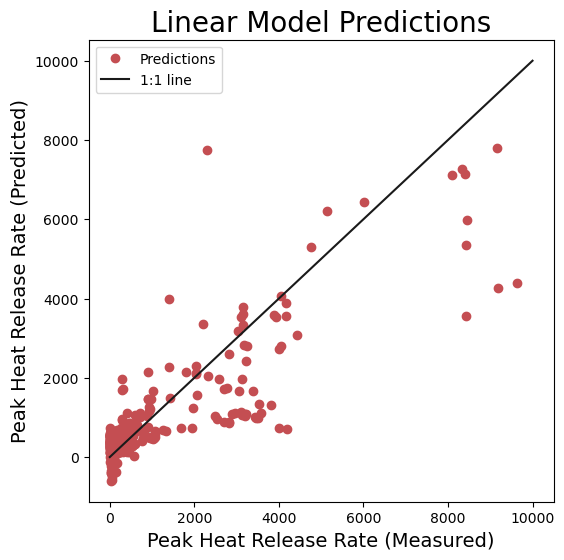

In [139]:
y_train_pred = gs.predict(X_train)
prediction_plot(y_train_pred, 'Linear Model Predictions' )

### Observations : Linear Model does very poorly on this data set with an R2 score of -1.08

# Use Ensemble Methods to Predict Peak Heat Release Rate
## Optimized Decision Tree Regressor

In [140]:
# Find optimal depth of trees
cv_tree_dict = {}
for tree_depth in range(1,20):
    dtree = DecisionTreeRegressor(max_depth=tree_depth)
    cv_results = cross_val_score(dtree, X_train, y_train, scoring="r2", cv=10, n_jobs=-1)
    cv_tree_dict[tree_depth]=np.mean(cv_results)

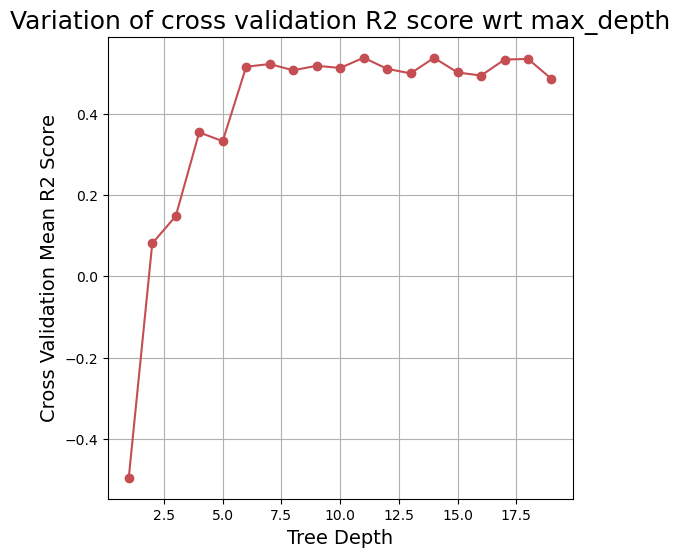

In [141]:
#Plot the variation of cross validation accuracy wrt max_depth
plt.plot(cv_tree_dict.keys(), cv_tree_dict.values(), 'ro-')
plt.xlabel("Tree Depth", fontsize=14)
plt.ylabel("Cross Validation Mean R2 Score", fontsize=14)
plt.title('Variation of cross validation R2 score wrt max_depth', fontsize=18)
plt.grid()
plt.show()

In [142]:
best_depth = [k for k,val in cv_tree_dict.items() if val == max(cv_tree_dict.values())]
print(f'Optimial Depth = {best_depth[0]}. Cross-validation R2 Score : {max(cv_tree_dict.values()).round(4)}')

Optimial Depth = 11. Cross-validation R2 Score : 0.5375


In [143]:
dtree = DecisionTreeRegressor(max_depth=best_depth[0])
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=11)

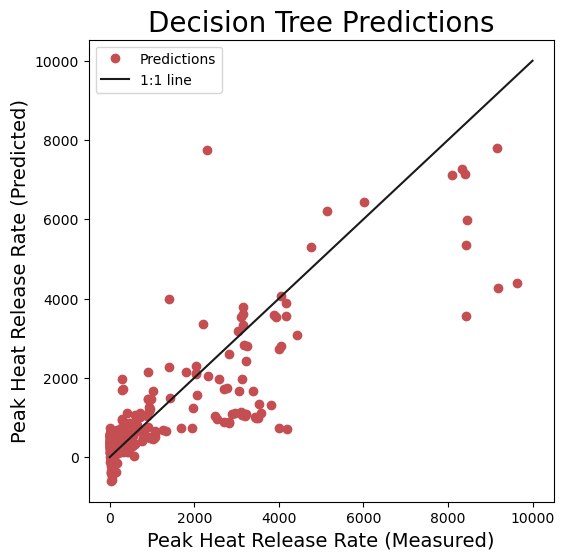

In [144]:
y_train_pred = gs.predict(X_train)
prediction_plot(y_train_pred, 'Decision Tree Predictions' )

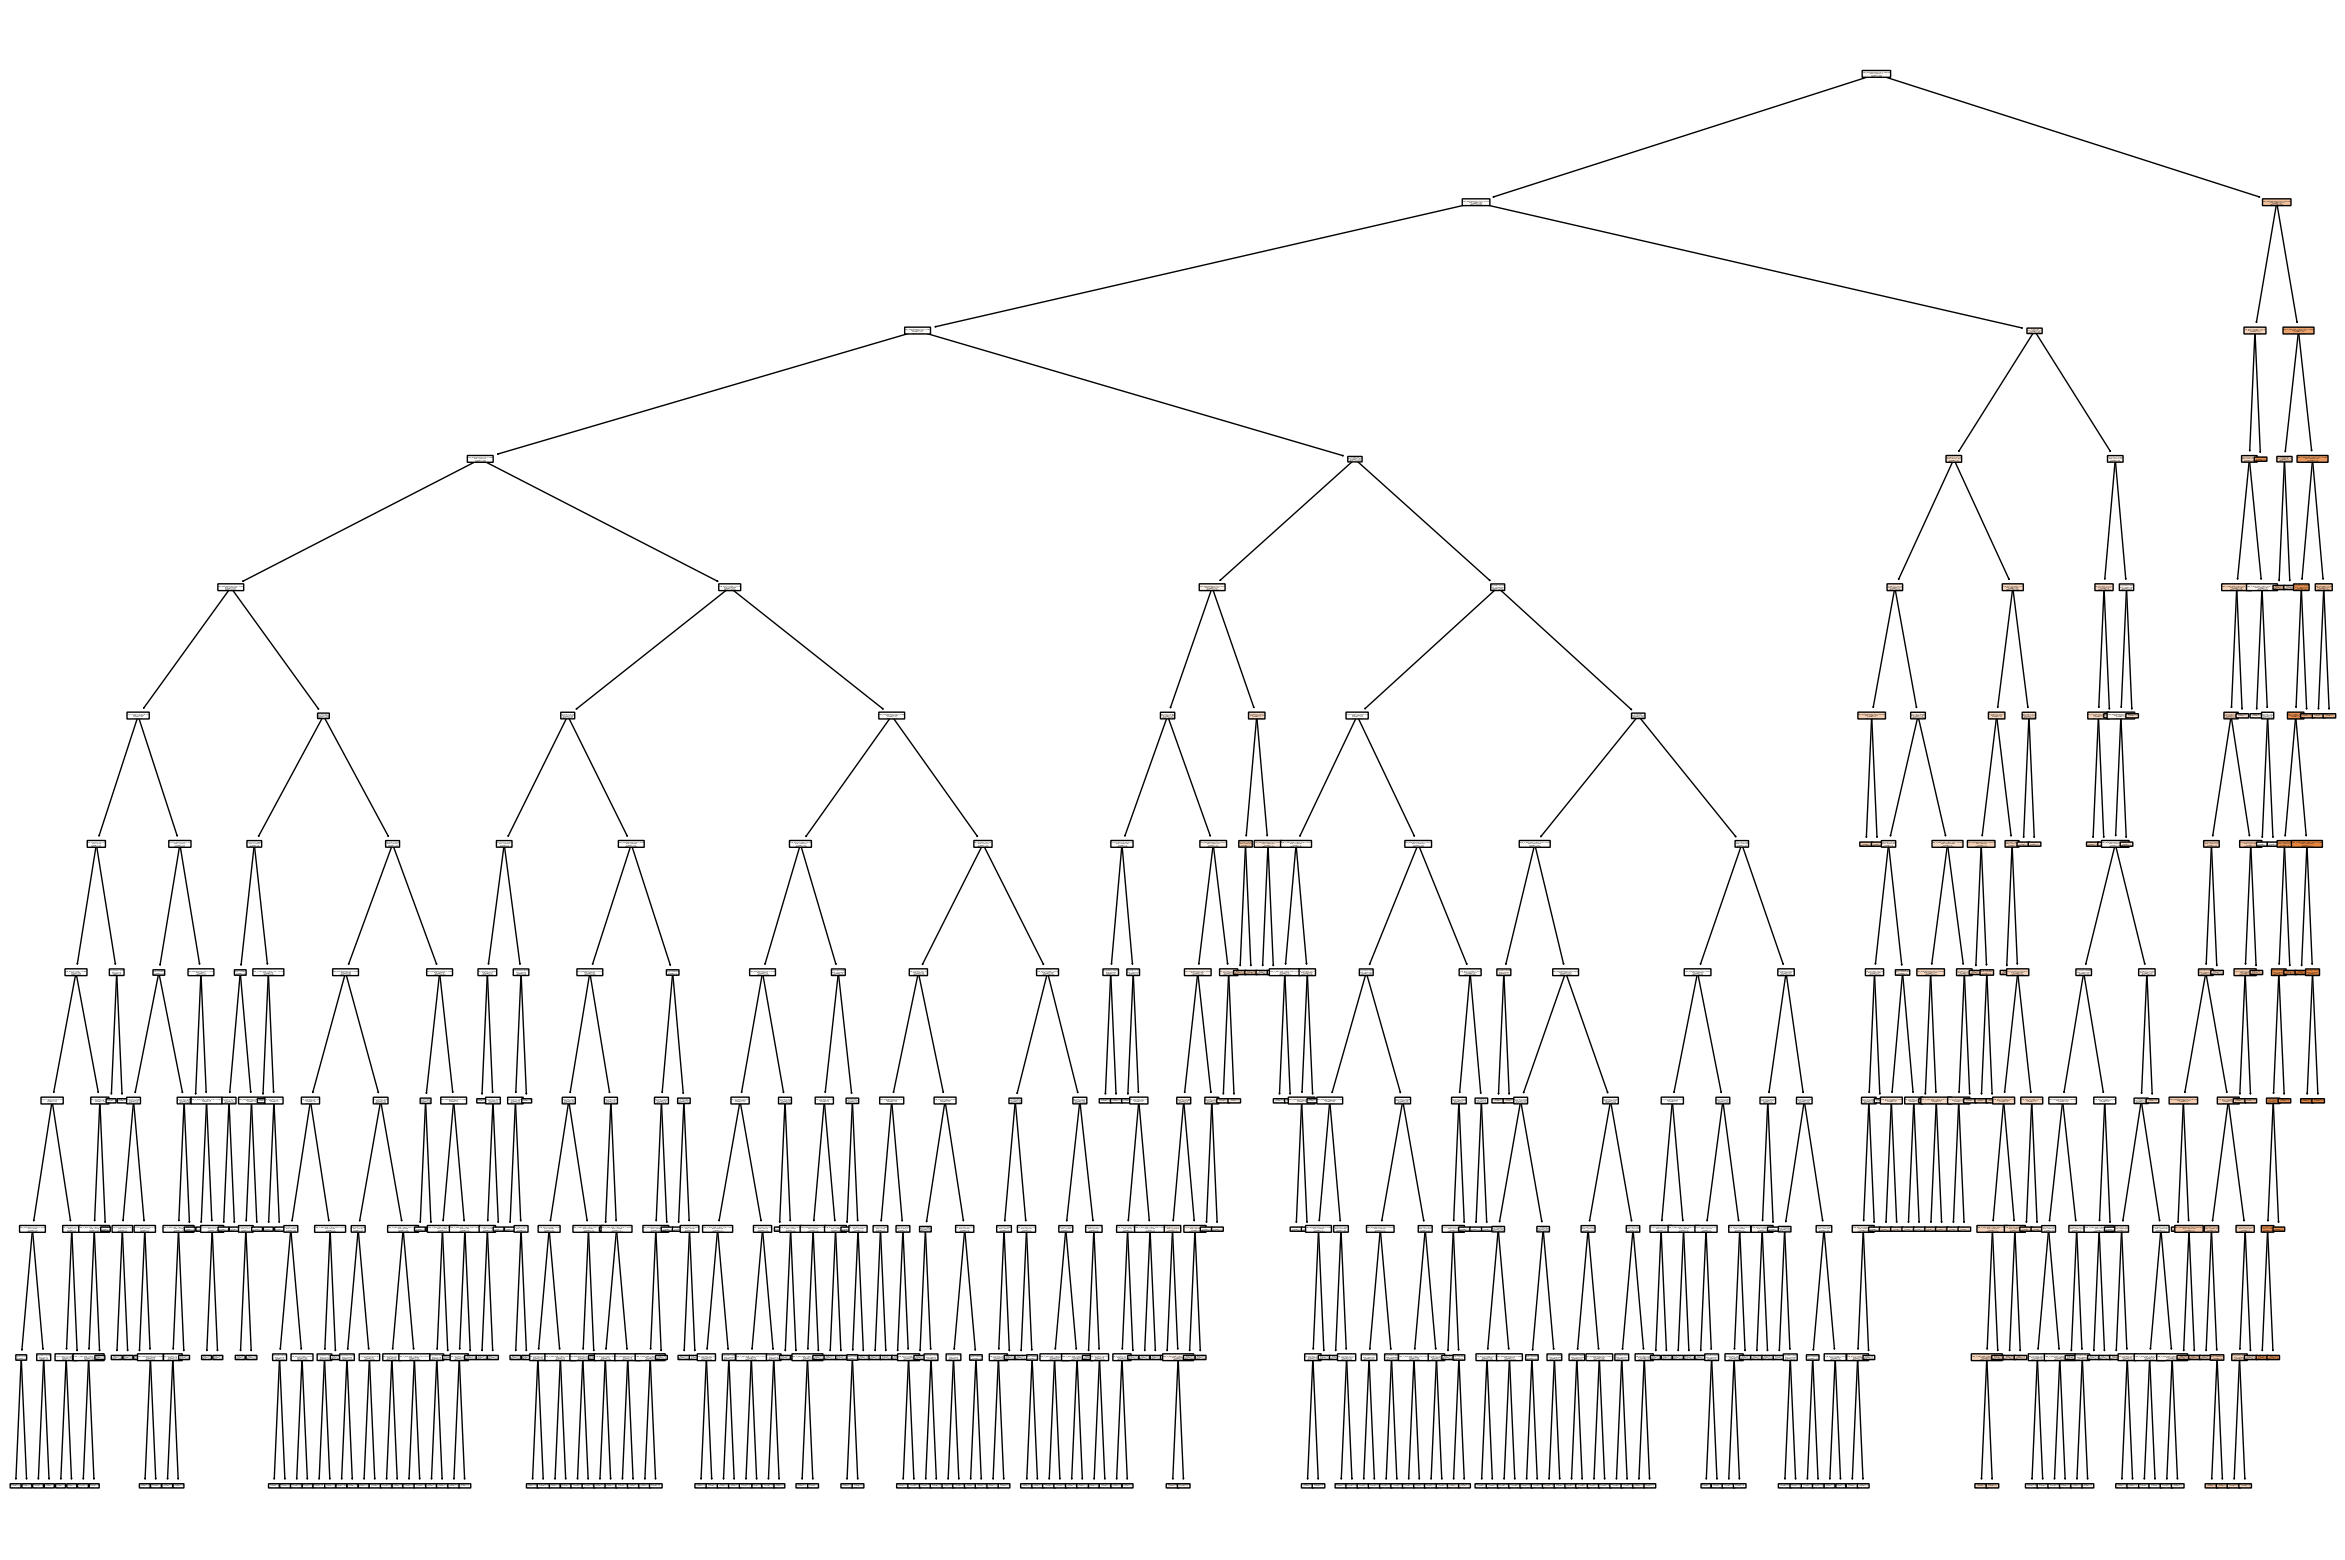

In [145]:
plt.figure(figsize=(30,20))
tree.plot_tree(dtree, filled=True, rounded=True, feature_names=df.columns.to_list())
plt.show()

# Pruning of Fully Grown Trees

In [146]:
ptree = DecisionTreeRegressor(max_depth=None)

In [147]:
path = ptree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [148]:
clfs = {}
pruning_max_depth =[]
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs[ccp_alpha]=clf
    pruning_max_depth.append(clfs[ccp_alpha].tree_.max_depth)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[ccp_alphas[-1]].tree_.max_depth, ccp_alphas[-1]))

Number of nodes in the last tree is: 0 with ccp_alpha: 762912.3965239655


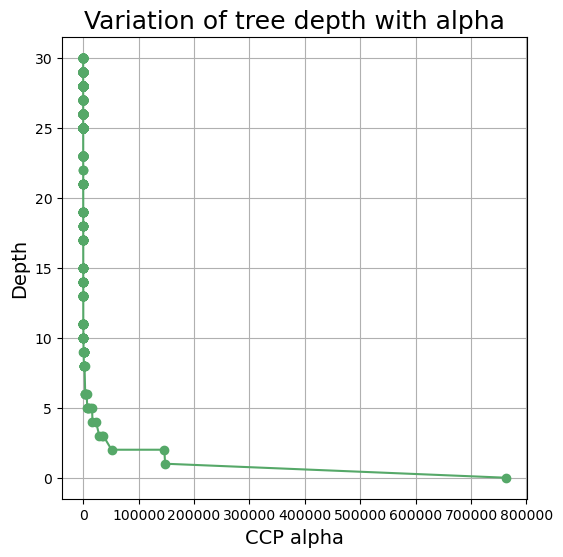

In [149]:
# Plot depth vs alpha

# Your code here
plt.plot(ccp_alphas, pruning_max_depth, 'go-')
plt.xlabel("CCP alpha", fontsize=14)
plt.ylabel("Depth", fontsize=14)
plt.title('Variation of tree depth with alpha', fontsize=18)
plt.grid()
plt.show()

In [150]:
cv_tree_dict={}
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    cv_results = cross_val_score(clf, X_train, y_train, scoring="r2", cv=10, n_jobs=-1)
    cv_tree_dict[ccp_alpha]=np.mean(cv_results)

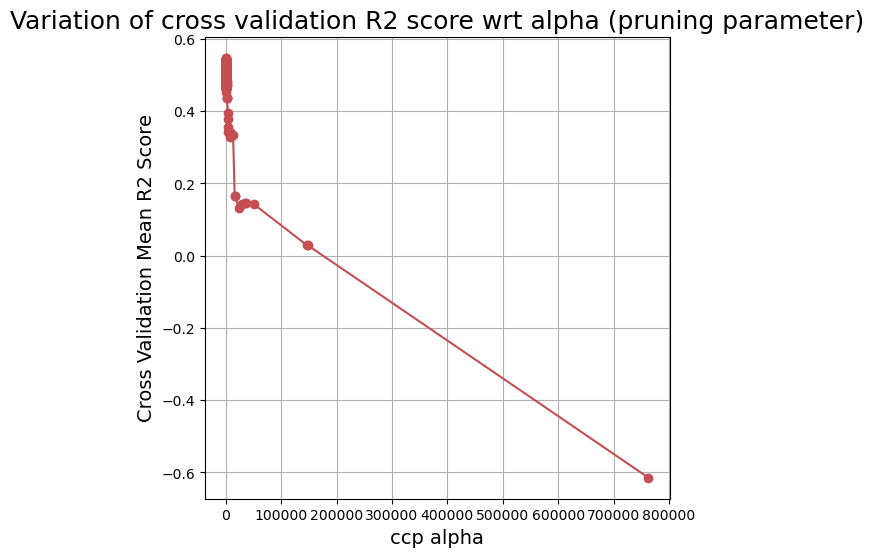

In [151]:
# best_ccp_alpha 
# Your code here
plt.plot(cv_tree_dict.keys(), cv_tree_dict.values(), 'ro-')
plt.xlabel("ccp alpha", fontsize=14)
plt.ylabel("Cross Validation Mean R2 Score", fontsize=14)
plt.title('Variation of cross validation R2 score wrt alpha (pruning parameter)', fontsize=18)
plt.grid()
plt.show()


In [152]:
values= list(cv_tree_dict.values())
keys = list(cv_tree_dict.keys())
m=max(values)
i=values.index(m)
#print(keys[i])
best_ccp_alpha = keys[i]

clf = DecisionTreeRegressor(ccp_alpha=best_ccp_alpha)
clf.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.06671439024382668)

# Bagging

In [153]:
# bagging_parameters
clf = DecisionTreeRegressor(max_depth=3)
bag = BaggingRegressor(base_estimator = clf, n_estimators=100, oob_score=True)
bag.fit(X_train, y_train)
bag.get_params().keys()

dict_keys(['base_estimator__ccp_alpha', 'base_estimator__criterion', 'base_estimator__max_depth', 'base_estimator__max_features', 'base_estimator__max_leaf_nodes', 'base_estimator__min_impurity_decrease', 'base_estimator__min_impurity_split', 'base_estimator__min_samples_leaf', 'base_estimator__min_samples_split', 'base_estimator__min_weight_fraction_leaf', 'base_estimator__random_state', 'base_estimator__splitter', 'base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [154]:
params = {'base_estimator__max_depth':[2,4,6,8,10,12,14,16,18], 'n_estimators':list(range(30,100,5))}
gs = GridSearchCV(estimator=bag, param_grid=params, scoring='r2', n_jobs=-1, refit=True, cv=10, return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                                        n_estimators=100, oob_score=True),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                       16, 18],
                         'n_estimators': [30, 35, 40, 45, 50, 55, 60, 65, 70,
                                          75, 80, 85, 90, 95]},
             return_train_score=True, scoring='r2')

In [155]:
# Print the best parameters
print(f'Best Parameters : {gs.best_params_}')

Best Parameters : {'base_estimator__max_depth': 10, 'n_estimators': 35}


In [156]:
print(f'Cross Validation  Mean R2 Score : {np.mean(gs.cv_results_["mean_test_score"] ).round(4) }')

Cross Validation  Mean R2 Score : 0.5747


In [157]:
# Get the best parameters
print(f'\033[1;91mBest Parameters : {gs.best_params_} \nBest Estimator : { gs.best_estimator_}')

Best Parameters : {'base_estimator__max_depth': 10, 'n_estimators': 35} 
Best Estimator : BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                 n_estimators=35, oob_score=True)


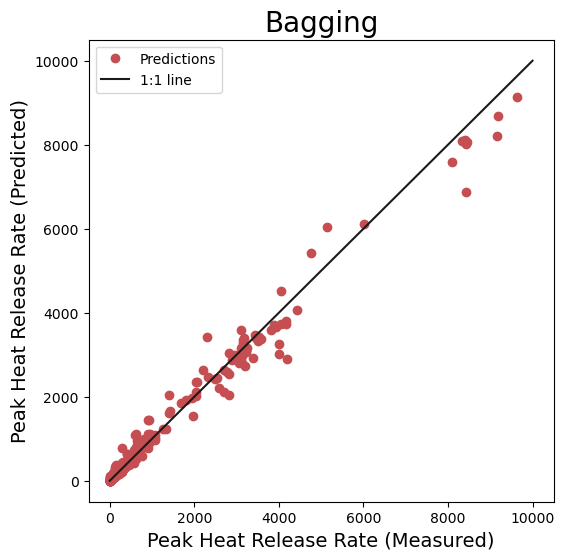

In [158]:
clf = DecisionTreeRegressor(max_depth=16)
bag = BaggingRegressor(base_estimator = clf, n_estimators=40, oob_score=True)
bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
prediction_plot(y_train_pred, 'Bagging' )

In [159]:
## Bagging Feature Importance - Permutation Importance

In [160]:
# Bagging importance
perm_results = permutation_importance(gs.best_estimator_, X_train, y_train, scoring="r2", n_repeats=5, n_jobs=-1)

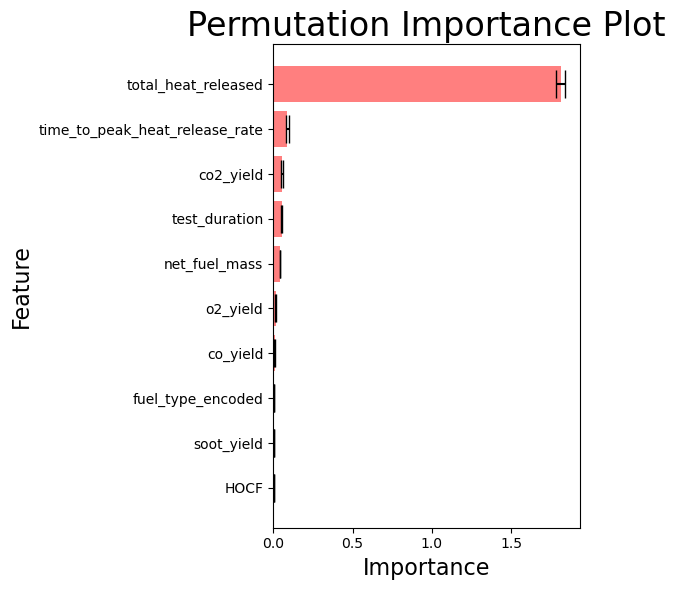

In [161]:
fig, ax = plt.subplots(figsize=(6,6))
list1 = perm_results['importances_mean']
list2 = df.drop(["id", "Peak_Heat_Release_Rate"], axis = 1).columns.to_list()
list3 = perm_results['importances_std']

list1a,list2 = zip(*sorted(zip(list1, list2)))
list1b,list3 = zip(*sorted(zip(list1, list3)))

ax.barh(list2, list1a, xerr=list3, align='center', alpha=0.5, ecolor='black', capsize=10, color='red')
ax.set_ylabel('Feature', fontsize=16)
ax.set_xlabel('Importance', fontsize=16)
ax.set_title('Permutation Importance Plot', fontsize=24)
plt.tight_layout()
plt.show()

# Random Forest

In [162]:
import itertools
param_dict = OrderedDict(n_estimators = [10, 20, 30, 40, 50, 100, 150, 200, 250], max_features = (range(2, 5)), max_depth=(range(2,10)))
E = [dict(zip(param_dict.keys(), a)) for a in itertools.product(*param_dict.values())]
print(len(E))
E[0]['n_estimators']

216


10

In [163]:
# Fit the model for all possible combinations of param_dict
oob_score=[]
for comb in E:
    rf = RandomForestRegressor(n_estimators=comb['n_estimators'], max_depth=comb['max_depth'], max_features=comb['max_features'], 
                                warm_start=True, oob_score=True)
    rf.fit(X_train, y_train)
    oob_score.append(rf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
Some inputs do not have OOB scores. This probabl

In [164]:
max_oob_score = max(oob_score)
max_index = oob_score.index(max_oob_score)
print(f'Best Estimator : {E[max_index]}')

Best Estimator : {'n_estimators': 150, 'max_features': 3, 'max_depth': 8}


In [165]:
# rf_best_params 

rf = RandomForestRegressor(n_estimators=E[max_index]['n_estimators'], max_depth=E[max_index]['max_depth'], max_features=E[max_index]['max_features'], 
                                warm_start=True, oob_score=True)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': True}

In [166]:
# Fit new model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=3, n_estimators=150,
                      oob_score=True, warm_start=True)

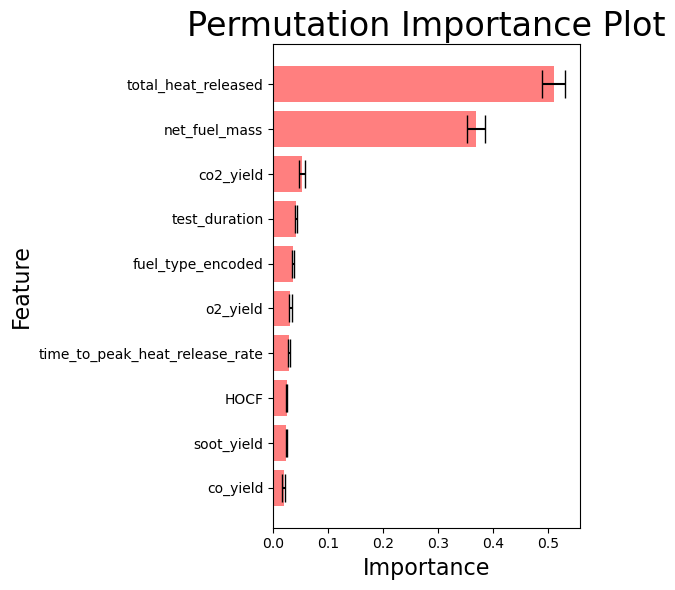

In [167]:
perm_results = permutation_importance(rf, X_train, y_train, scoring="r2", n_repeats=5, n_jobs=-1)
fig, ax = plt.subplots(figsize=(6,6))
list1 = perm_results['importances_mean']
list2 = df.drop(["id", "Peak_Heat_Release_Rate"], axis = 1).columns.to_list()
list3 = perm_results['importances_std']

list1a,list2 = zip(*sorted(zip(list1, list2)))
list1b,list3 = zip(*sorted(zip(list1, list3)))

ax.barh(list2, list1a, xerr=list3, align='center', alpha=0.5, ecolor='black', capsize=10, color='red')
ax.set_ylabel('Feature', fontsize=16)
ax.set_xlabel('Importance', fontsize=16)
ax.set_title('Permutation Importance Plot', fontsize=24)
plt.tight_layout()
plt.show()

# Use LIME and Shapley Values to estimate Feature Importance.

In [168]:
df_train = df.drop(["id", "Peak_Heat_Release_Rate"], axis = 1)


In [169]:
!pip install shap


In [170]:
# load JS visualization code to notebook
import shap
shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
n=0
shap.force_plot(rf.predict(X_train).mean(), shap_values[n,:], df_train.iloc[n,:])

In [171]:
n=100
shap.force_plot(rf.predict(X_train).mean(), shap_values[n,:], df_train.iloc[n,:])

In [172]:
# load JS visualization code to notebook
shap.initjs()

# visualize the training set predictions
shap.force_plot(rf.predict(X_train).mean(), shap_values, df_train)

# Shap Dependence Plots

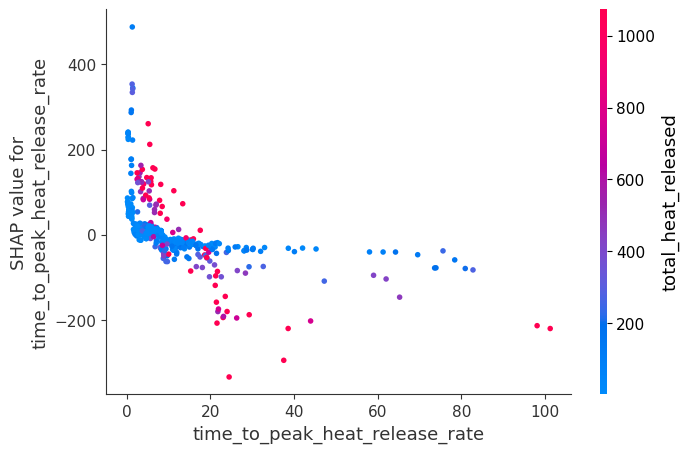

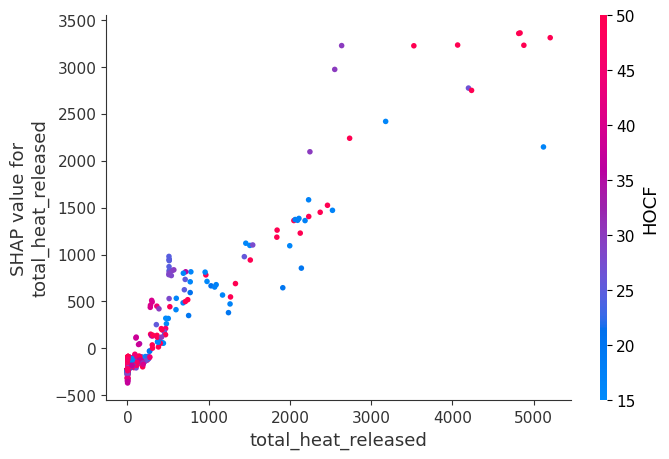

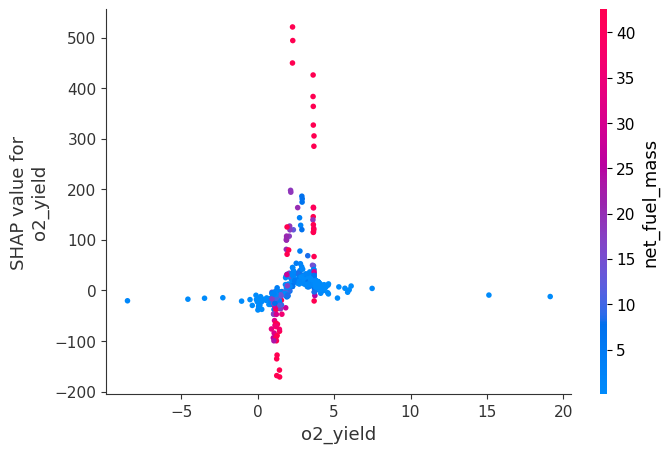

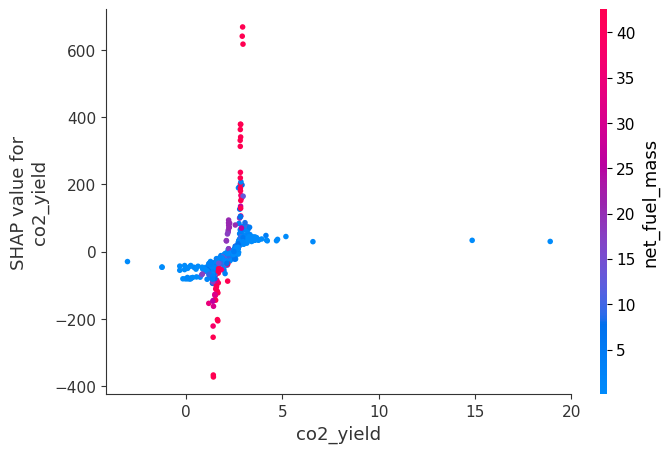

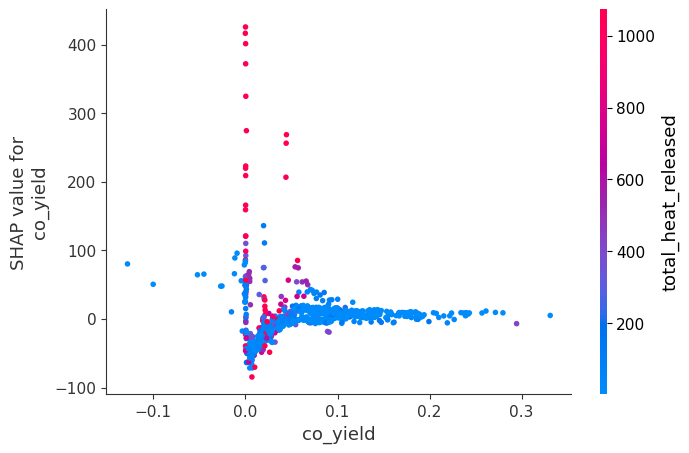

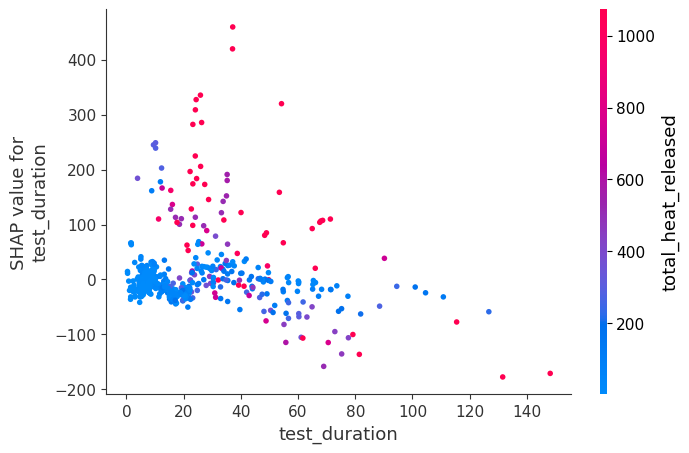

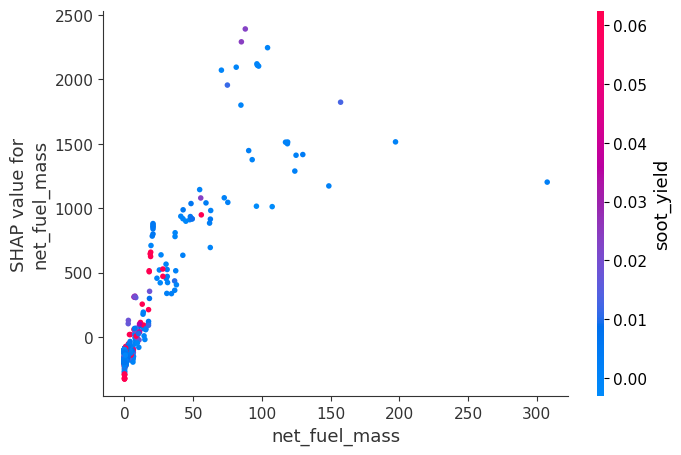

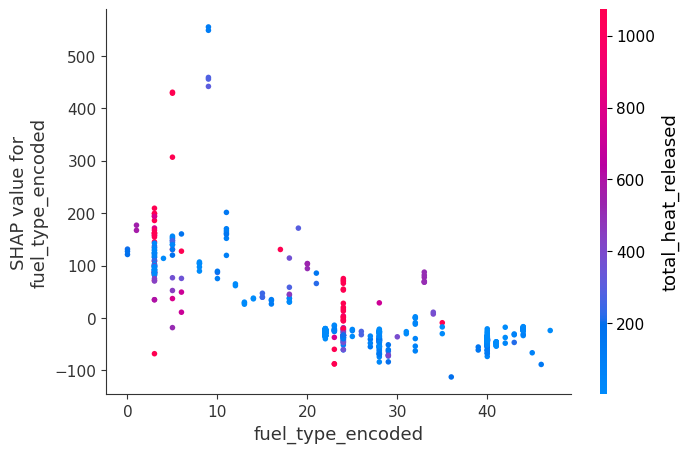

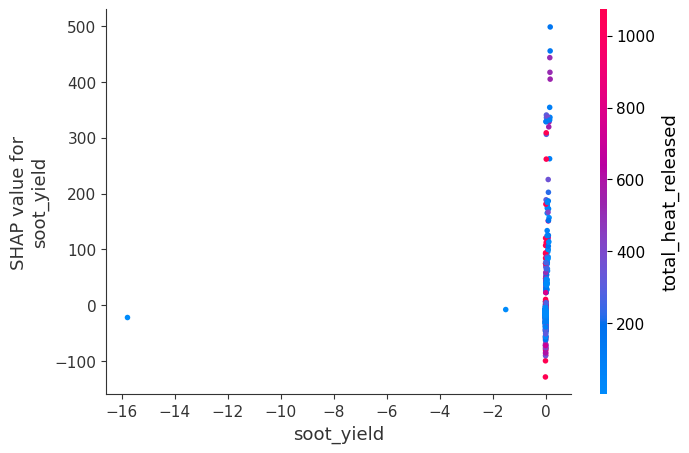

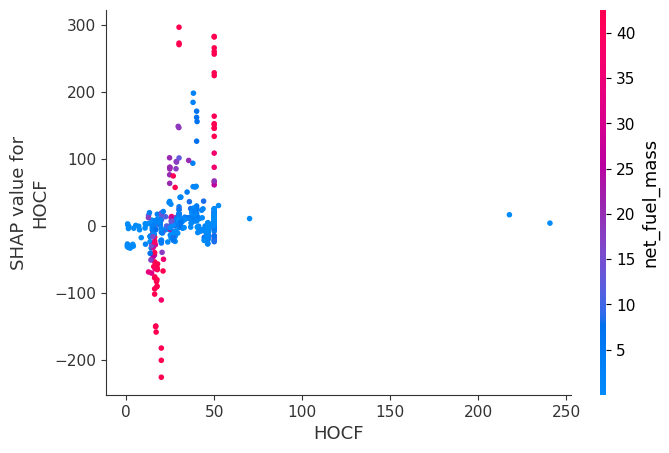

In [173]:
# You can use dependence_plot function to create a dependence plot to show the effect
# of a single feature across the whole dataset.

for feature in df_train.columns.to_list():
    shap.dependence_plot(feature, shap_values, df_train)

# Shap Values Summary Plot

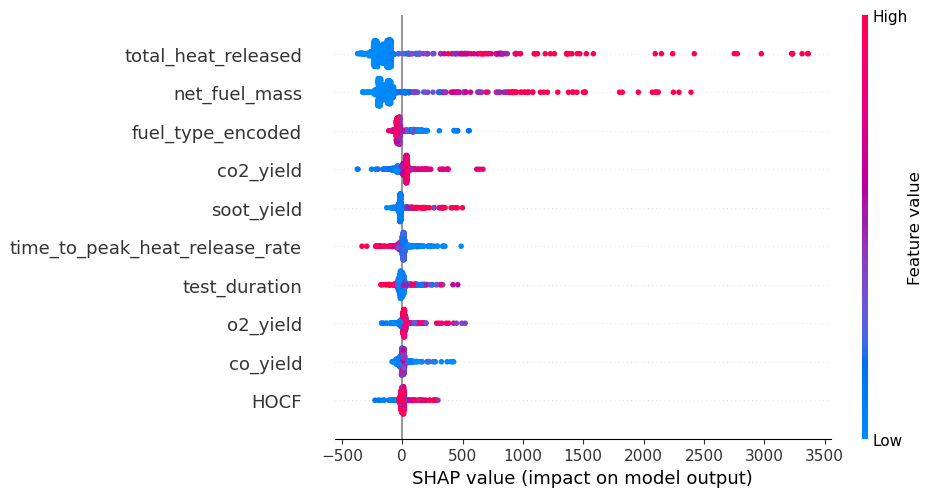

In [174]:
# You can use summary_plot function to summarize the effects of all the features.
shap.summary_plot(shap_values, df_train)

# Feature Global importance plots

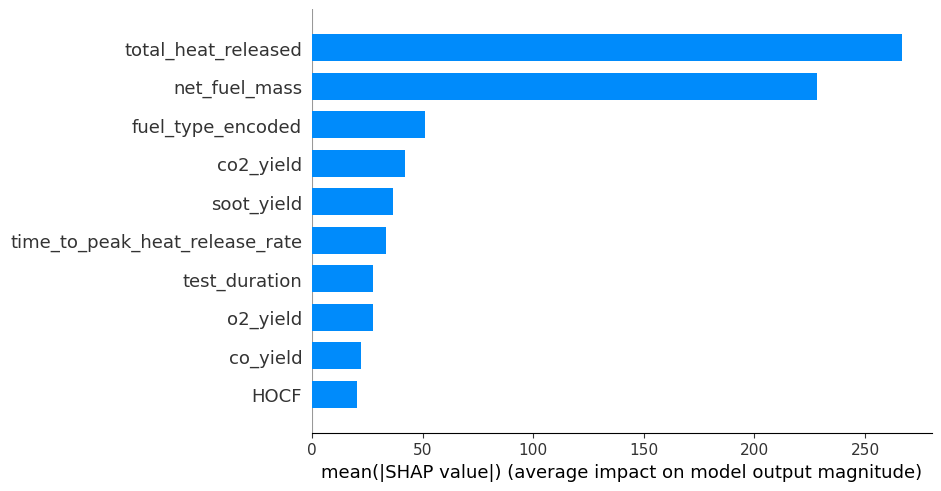

In [175]:
# We can also just take the mean absolute value of the SHAP values for each
# feature to get a standard bar plot:

shap.summary_plot(shap_values, df_train, plot_type="bar")

In [176]:
!pip install lime

In [177]:
# Now use a lime explainer for tabular data
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train,
    feature_names = df_train.columns.to_list(),
    mode='regression')

# And explain a prediction
exp = explainer.explain_instance(X_train[1], rf.predict,
        num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)
plt.savefig("lime.png")

<Figure size 600x600 with 0 Axes>

In [178]:
print(exp.as_list())

[('total_heat_released > 65.51', 1230.477021614159), ('net_fuel_mass > 2.54', 1179.325977339161), ('co2_yield <= 2.16', -123.63099843276669), ('24.00 < fuel_type_encoded <= 40.00', -113.5976941603374), ('soot_yield > 0.01', 107.18970793820887), ('time_to_peak_heat_release_rate > 8.88', -71.95368837073244), ('o2_yield <= 2.09', -58.82029197189408), ('HOCF <= 30.00', -38.95035769468007), ('0.06 < co_yield <= 0.10', 10.46921414164291), ('test_duration > 21.20', -5.357507661402832)]
